In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from util import *

In [3]:
columns = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

Omega = np.load("../genai/scenarios.npy")
df = pd.DataFrame(Omega[0], columns=columns)



In [ ]:

print(df.columns)
fixed_window = pd.read_csv('../genai/fixed_window.csv', index_col=0)
print(fixed_window.columns)
fixed_window.columns = columns
print(fixed_window.columns)
df = pd.concat([fixed_window, df])
print(df.columns)
try:
    
    df['T2M'] = (df["T2M_MIN"] + df["T2M_MAX"])/2 
    print(df.columns)
    df.rename(columns={"ALLSKY_SFC_SW_DWN":"RS", "CLRSKY_SFC_SW_DWN": "RSO",
                "PRECTOTCORR": "PRECIPITATION"}, inplace=True)
    # CLRSKY_SFC_SW_DWN?
    df['RSO'] = df['RS']
    print(df.columns)
    # Merge with real data and fix scenario generation according tactical planning  
    df_season = df#.loc['2022-11-01':'2023-04-29'].copy()
    if len(df_season) < 180:
        print(f"Warning: Season data is short ({len(df_season)} days). Using available data.")
    else:
        df_season = df_season.iloc[:180]
    print(f"Loaded {len(df_season)} days of weather data for simulation.")
except FileNotFoundError:
    print("="*50)
    print("ERROR: Data file not found. Please re-run Cell 4 to download the data.")
    print("="*50)

Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M', 'T2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECIPITATION', 'RS', 'RH2M', 'WS2M', 'T2M',
       'RSO'],
      dtype='object')
Loaded 180 days of weather data for simulation.


In [5]:
df_season.reset_index(inplace=True)


In [6]:
# ==============================================
# 2.0) OLIVE CROP PARAMETERS
# ==============================================
print("Olive parameters loaded.")
print(f"  Yield Coeff (CCh): {CCh}")
print(f"  Thermal Time (Tsum): {Tsum} GDD")
print(f"  Soil TAW (Max): {critical_water} mm")
print(f"  Soil RAW (Trigger): {critical_depletion} mm")


Olive parameters loaded.
  Yield Coeff (CCh): 0.0405
  Thermal Time (Tsum): 2000 GDD
  Soil TAW (Max): 160 mm
  Soil RAW (Trigger): 80 mm


In [7]:
# --- Pre-calculate all environmental factors ---
df_season['FTemp'] = fTemp(Tbase, Topt, df_season['T2M'])
df_season['FHeat'] = fHeat(Theat, Textreme, df_season['T2M_MAX'])
df_season['FSolar'] = fSolar(fSolarmax, I50A, I50B, Tsum, Tbase, df_season['T2M'])
ETO_series, ETC_series = RN(alfa, df_season['RS'], df_season['RSO'], SIGMA,
                             df_season['T2M_MIN'], df_season['T2M_MAX'],
                             df_season['RH2M'], df_season['T2M'],
                             Altitude, n, E, Cp, G, df_season['WS2M'])
df_season['ETO'] = ETO_series
df_season['ETC'] = ETC_series

# Potential biomass accumulation factor
df_season['EF_t'] = df_season['RS'] * df_season['FSolar'] * df_season['FTemp'] * SCO2

print("Environmental factors pre-calculated.")


Environmental factors pre-calculated.


C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['FTemp'] = fTemp(Tbase, Topt, df_season['T2M'])
C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['FHeat'] = fHeat(Theat, Textreme, df_season['T2M_MAX'])
C:\Users\fperezg\AppData\Local\Temp\ipykernel_20744\1867912525.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
print("SIMPLE model function defined.")

SIMPLE model function defined.


In [ ]:
print("Running 'Rainfed' scenario...")
df_rainfed = run_simple_model(df_season, 'rainfed')

print("Running 'Optimized' scenario...")
df_optimized = run_simple_model(df_season, 'optimized')

print("Simulations complete.")

Running 'Rainfed' scenario...
Running 'Optimized' scenario...
Simulations complete.


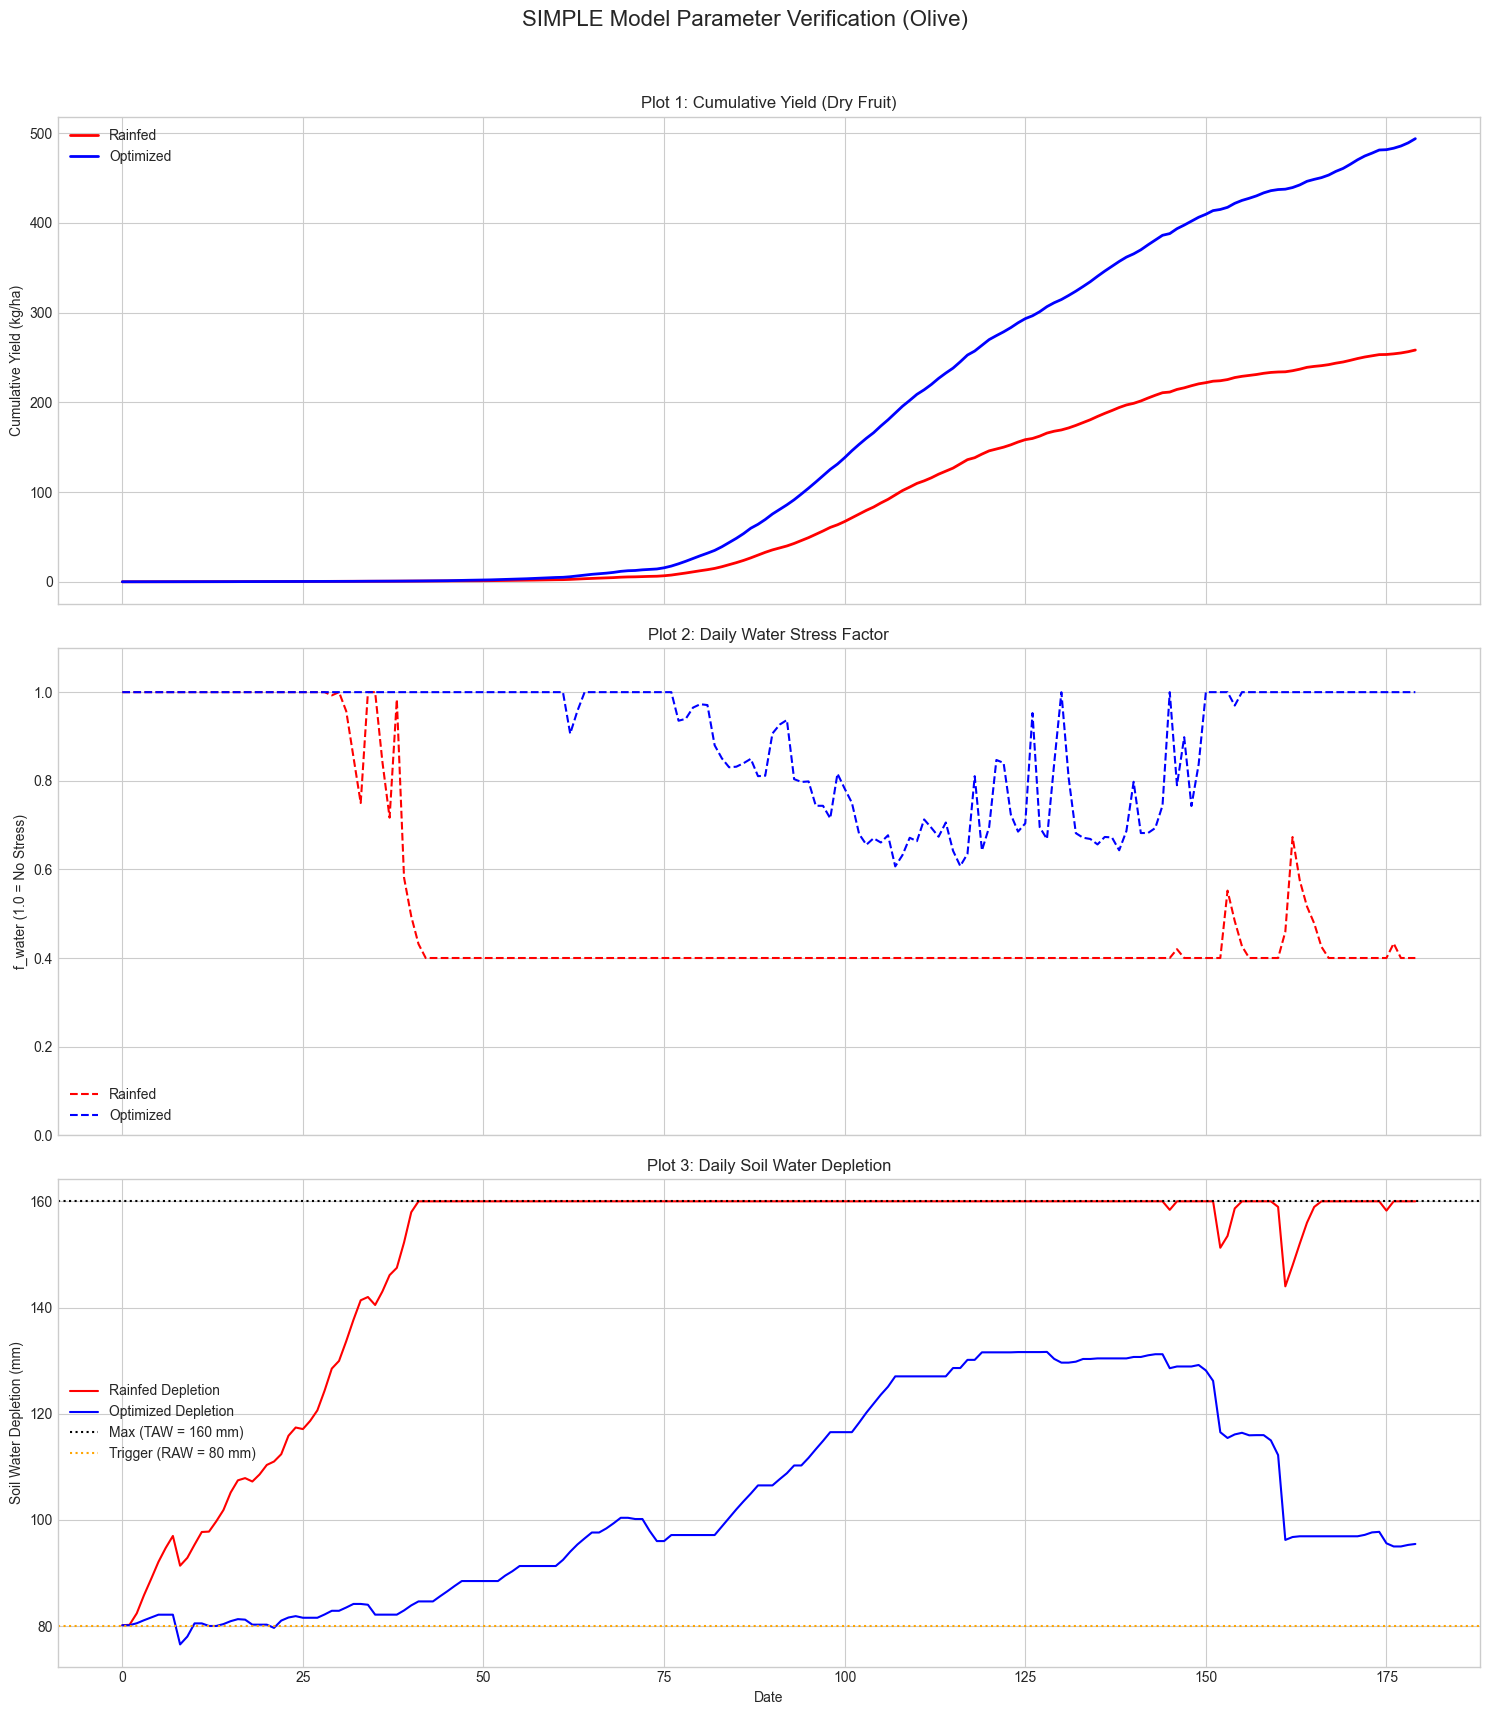


FINAL SIMULATION SUMMARY
--- Rainfed Scenario ---
  Total Yield:       258 kg/ha (Dry Fruit)
  Total Water (Rain): 76 mm
  Avg. f_water:      0.53

--- Optimized Scenario ---
  Total Yield:       494 kg/ha (Dry Fruit)
  Total Water (Rain): 76 mm
  Total Irrigation:  784 mm
  Avg. f_water:      0.90



In [ ]:

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle('SIMPLE Model Parameter Verification (Olive)', fontsize=16)

# --- Plot 1: Cumulative Yield ---
ax1.plot(df_rainfed.index, df_rainfed['Cumulative_Yield_kgHa'],
         label='Rainfed', color='red', linewidth=2)
ax1.plot(df_optimized.index, df_optimized['Cumulative_Yield_kgHa'],
         label='Optimized', color='blue', linewidth=2)
ax1.set_ylabel('Cumulative Yield (kg/ha)')
ax1.set_title('Plot 1: Cumulative Yield (Dry Fruit)')
ax1.legend()

# --- Plot 2: Water Stress (f_water) ---
ax2.plot(df_rainfed.index, df_rainfed['f_water'],
         label='Rainfed', color='red', linestyle='--')
ax2.plot(df_optimized.index, df_optimized['f_water'],
         label='Optimized', color='blue', linestyle='--')
ax2.set_ylabel('f_water (1.0 = No Stress)')
ax2.set_title('Plot 2: Daily Water Stress Factor')
ax2.set_ylim(0, 1.1)
ax2.legend()

# --- Plot 3: Soil Water Depletion ---
ax3.plot(df_rainfed.index, df_rainfed['Depletion_mm'],
         label='Rainfed Depletion', color='red')
ax3.plot(df_optimized.index, df_optimized['Depletion_mm'],
         label='Optimized Depletion', color='blue')

# Plot the TAW and RAW thresholds
ax3.axhline(y=critical_water, color='black', linestyle=':',
            label=f'Max (TAW = {critical_water} mm)')
ax3.axhline(y=critical_depletion, color='orange', linestyle=':',
            label=f'Trigger (RAW = {critical_depletion} mm)')

ax3.set_ylabel('Soil Water Depletion (mm)')
ax3.set_title('Plot 3: Daily Soil Water Depletion')
ax3.set_xlabel('Date')
ax3.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


print("\n" + "="*50)
print("FINAL SIMULATION SUMMARY")
print("="*50)

# Rainfed Results
final_yield_rf = df_rainfed['Cumulative_Yield_kgHa'].iloc[-1]
total_precip = df_season['PRECIPITATION'].sum()

# Optimized Results
final_yield_opt = df_optimized['Cumulative_Yield_kgHa'].iloc[-1]
total_irrigation_opt = df_optimized['Irrigation_mm'].sum()

print(f"--- Rainfed Scenario ---")
print(f"  Total Yield:       {final_yield_rf:.0f} kg/ha (Dry Fruit)")
print(f"  Total Water (Rain): {total_precip:.0f} mm")
print(f"  Avg. f_water:      {df_rainfed['f_water'].mean():.2f}\n")

print(f"--- Optimized Scenario ---")
print(f"  Total Yield:       {final_yield_opt:.0f} kg/ha (Dry Fruit)")
print(f"  Total Water (Rain): {total_precip:.0f} mm")
print(f"  Total Irrigation:  {total_irrigation_opt:.0f} mm")
print(f"  Avg. f_water:      {df_optimized['f_water'].mean():.2f}\n")

print("="*50)

# 2025-12-02 Crop model

      >>> MODEL CALIBRATION GUIDE: PARAMETERS TO TUNE <<<
To adapt this model to a REAL site, modify these keys in 'params':
1. PHENOLOGY:
   - 'Ccrit': Critical Chilling Units. Lower it if trees bloom too late.
   - 'FcritFlo': Thermal forcing units. Adjusts flowering date.
2. SOIL & WATER:
   - 'TTSW1'/'TTSW2': Soil water holding capacity (Texture/Depth).
   - 'Irrigation_Threshold': 0.85 = No Stress, 0.50 = Deficit Irrigation.
3. ARCHITECTURE:
   - 'PlantD': Planting Density (Trees/ha).
   - 'LAD': Leaf Area Density. High density = more shading.

[ERROR] File not found: /content/datos_nasa/cl_co_power_daily_20190331_20240331.csv. Generating dummy data.
[INFO] Chile season subset enabled: 2021-09-01 -> 2022-05-31
[INFO] Final modelling dataframe: 2021-09-01 -> 2022-05-31 | n=273
--- STARTING SIMULATION: Terramater (Olivares de Peteroa) ---
Strategy: Irrigation Threshold 20.0%
[PHENO] 2021-10-15 ❄️ Dormancy Released (Chill: 354)
[PHENO] 2022-01-14 🌸 ANTHESIS (Flowering)
  [JAN] 2022 |

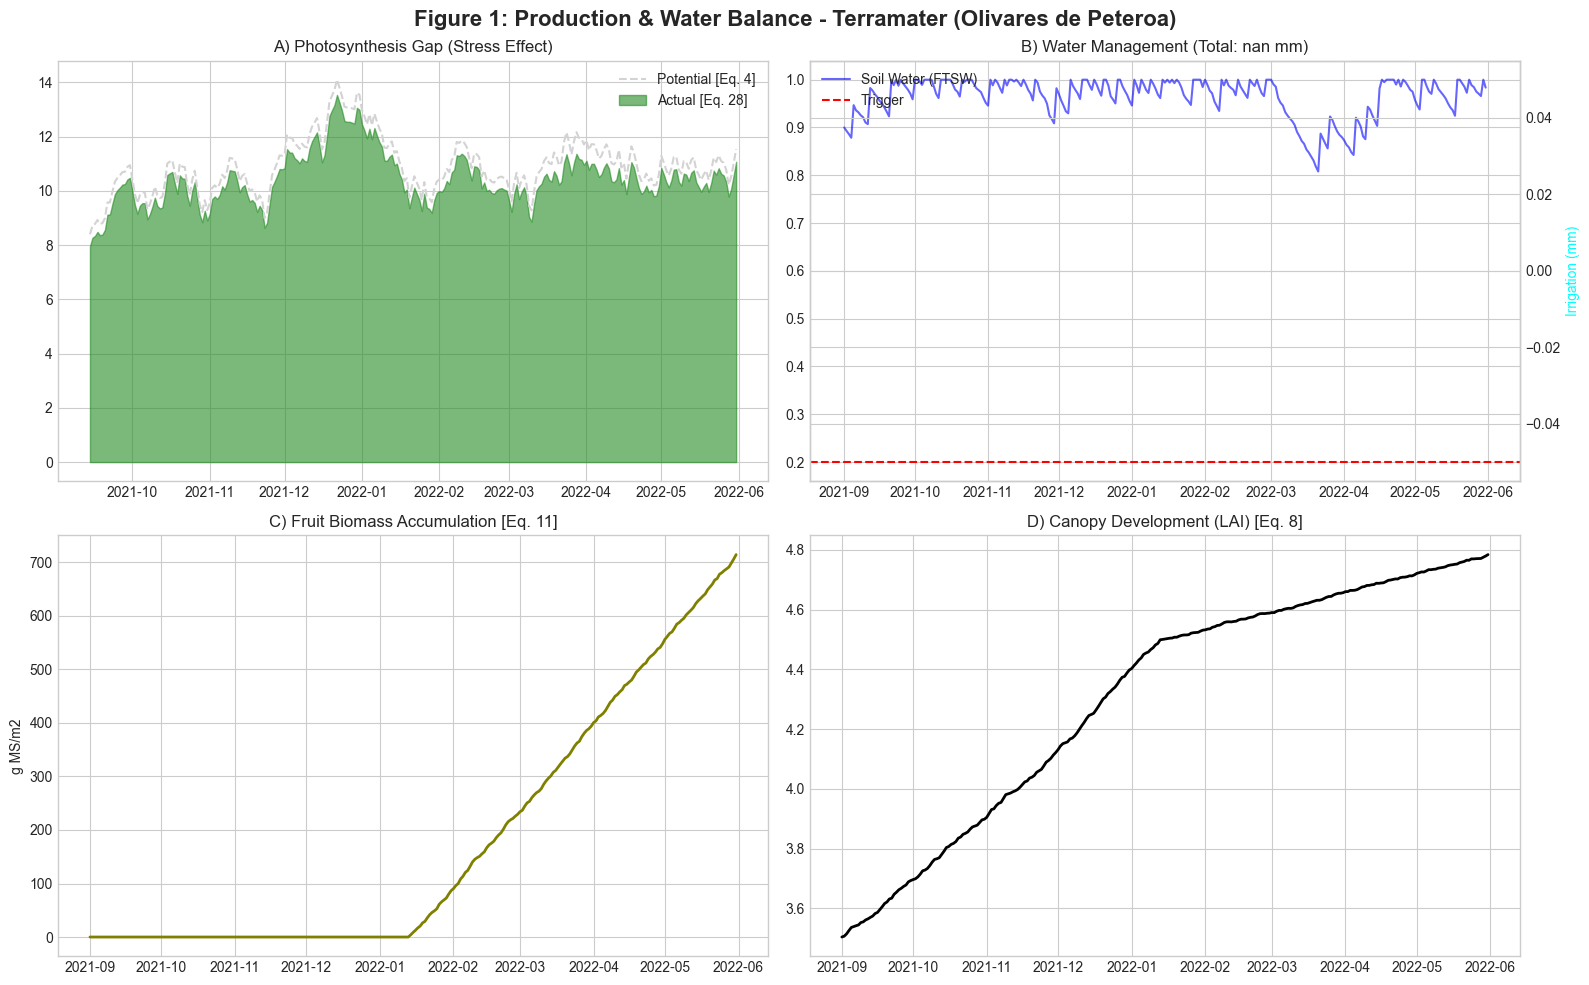

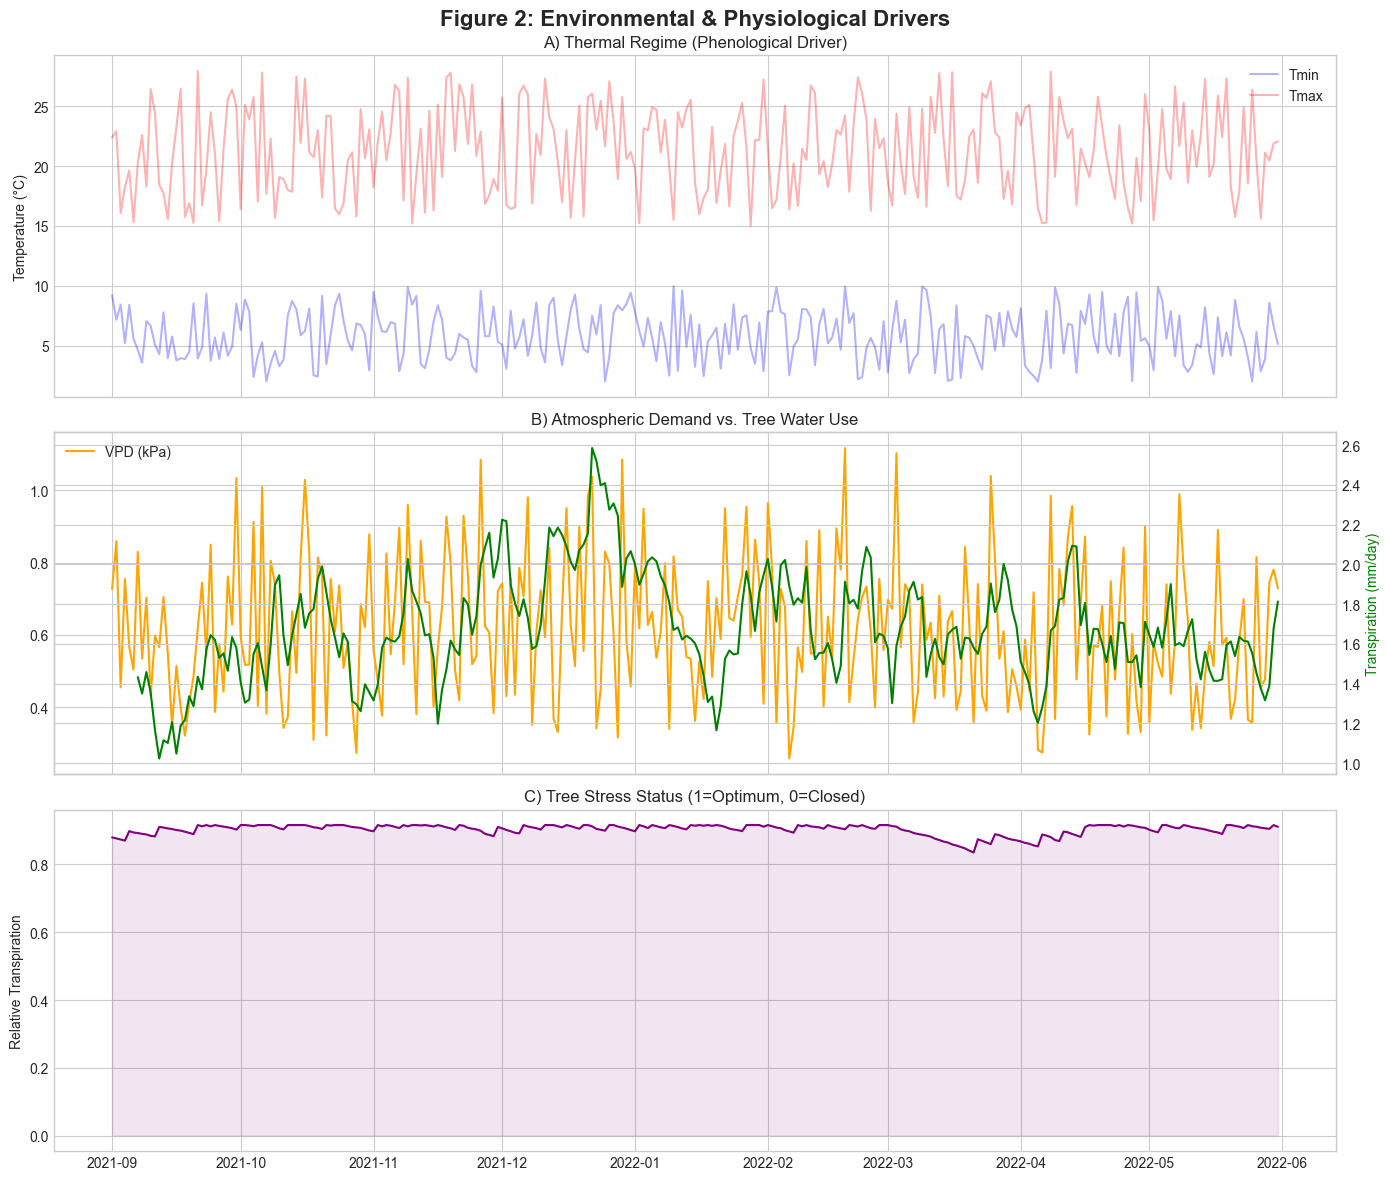


[Image of Soil Plant Atmosphere Continuum diagram]


In [ ]:
# ============================================
# OLIVE PROCESS-BASED MODEL (ENGLISH VERSION)
# Reference: Moriondo et al. (2019) / Villalobos et al. (2013)
# Configuration: Super-Intensive Arbequina (Chile)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================================
# 0. CALIBRATION GUIDE (READ FIRST)
# ==========================================================
print("="*60)
print("      >>> MODEL CALIBRATION GUIDE: PARAMETERS TO TUNE <<<")
print("="*60)
print("To adapt this model to a REAL site, modify these keys in 'params':")
print("1. PHENOLOGY:")
print("   - 'Ccrit': Critical Chilling Units. Lower it if trees bloom too late.")
print("   - 'FcritFlo': Thermal forcing units. Adjusts flowering date.")
print("2. SOIL & WATER:")
print("   - 'TTSW1'/'TTSW2': Soil water holding capacity (Texture/Depth).")
print("   - 'Irrigation_Threshold': 0.85 = No Stress, 0.50 = Deficit Irrigation.")
print("3. ARCHITECTURE:")
print("   - 'PlantD': Planting Density (Trees/ha).")
print("   - 'LAD': Leaf Area Density. High density = more shading.")
print("="*60 + "\n")


# ==========================================================
# 1. SETUP AND DATA LOADING (Chile-aware + One-Season Ready)
# ==========================================================
DATA_PATH = # "/content/datos_nasa/cl_co_power_daily_20190331_20240331.csv"
LOC = "Terramater (Olivares de Peteroa)"
VERBOSE = True

# --- Chile season controls (Southern Hemisphere) ---
# Season definition: Sep 1 (year Y) -> May 31 (year Y+1)
MODEL_ONE_SEASON = True
SEASON_START_YEAR = 2021        # models season 2021-2022 (Sep 2021 to May 2022)
SEASON_START_MD = (9, 1)
SEASON_END_MD   = (5, 31)

# If you prefer full multi-year runs, set MODEL_ONE_SEASON=False and use these:
START_DATE, END_DATE = "2020-01-01", "2023-12-31"

# --- Load or create dummy ---
if not os.path.exists(DATA_PATH):
    print(f"[ERROR] File not found: {DATA_PATH}. Generating dummy data.")
    dates = pd.date_range(start="2019-03-31", end="2024-03-31", freq="D")
    df_all = pd.DataFrame({
        "LOCATION": [LOC]*len(dates),
        "T2M_MAX": np.random.uniform(15, 28, len(dates)),
        "T2M_MIN": np.random.uniform(2, 10, len(dates)),
        "ALLSKY_SFC_SW_DWN": np.random.uniform(8, 28, len(dates)),
        "PRECTOTCORR": np.random.choice([0, 0, 0, 15], len(dates)),
        "RH2M": np.random.uniform(40, 80, len(dates))
    }, index=dates)
    df_all.index.name = "DATE"
else:
    df_all = pd.read_csv(DATA_PATH, parse_dates=["DATE"]).set_index("DATE").sort_index()

# --- Filter location ---
if "LOCATION" not in df_all.columns:
    raise ValueError("Expected column 'LOCATION' not found in the input file.")
df_raw = df_all[df_all["LOCATION"] == LOC].copy()

# --- Choose modeling window (one Chile season or multi-year) ---
if MODEL_ONE_SEASON:
    start = pd.Timestamp(SEASON_START_YEAR, SEASON_START_MD[0], SEASON_START_MD[1])
    end   = pd.Timestamp(SEASON_START_YEAR + 1, SEASON_END_MD[0], SEASON_END_MD[1])
    if VERBOSE:
        print(f"[INFO] Chile season subset enabled: {start.date()} -> {end.date()}")
    df = df_raw.loc[(df_raw.index >= start) & (df_raw.index <= end)].copy()
    full_range = pd.date_range(start=start, end=end, freq="D")
else:
    df = df_raw.loc[(df_raw.index >= START_DATE) & (df_raw.index <= END_DATE)].copy()
    full_range = pd.date_range(start=START_DATE, end=END_DATE, freq="D")

# --- Safety: enforce daily continuity + conservative interpolation ---
if len(df) == 0:
    raise ValueError(
        "No data after filtering by LOCATION and date window. "
        "Check LOC spelling and your date range vs. file coverage."
    )

missing = full_range.difference(df.index)
if len(missing) > 0:
    print(f"[INFO] Missing {len(missing)} day(s). Reindexing and interpolating (time-based).")
    df = df.reindex(full_range)

    # Interpolate only numeric weather columns; keep LOCATION as LOC
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].interpolate(method="time", limit_direction="both")

    # Restore LOCATION column
    if "LOCATION" in df.columns:
        df["LOCATION"] = LOC

# --- Minimal QC: clip RH2M to physical bounds and prevent negatives where impossible ---
if "RH2M" in df.columns:
    df["RH2M"] = df["RH2M"].clip(lower=0, upper=100)

for col in ["PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

if VERBOSE:
    print(f"[INFO] Final modelling dataframe: {df.index.min().date()} -> {df.index.max().date()} | n={len(df)}")

# ==========================================================
# 2. PARAMETERIZATION (Mapped to Sources)
# ==========================================================
params = dict(
    # --- ARCHITECTURE (Arbequina Super-Intensive) ---
    PlantD = 1600.0,      # [Trees/ha] Density 1.5x4m. (Source: Farm Management)
    PlantA = 10000/1600,  # [m2] Area per tree.
    LAD    = 2.0,         # [m2/m3] Leaf Area Density. (Source: Villalobos et al., 2013)

    # --- PHENOLOGY (De Melo-Abreu et al. 2004) ---
    # Chill: Triangular function parameters
    T_opt_chill = 7.2,    # [°C] Optimal Chilling Temp.
    T_max_chill = 16.0,   # [°C] Max Effective Temp.
    Ccrit       = 350.0,  # [Chill Units] Dormancy Break Threshold. (Source: De Melo-Abreu)

    # Forcing: Heat accumulation
    Tb_forcing  = 9.0,    # [°C] Base Temp. (Source: Alcalá & Barranco 1992)
    FcritFlo    = 450.0,  # [GDD] Growing Degree Days to Flower. (Source: Moriondo)

    # --- PHOTOSYNTHESIS & GROWTH ---
    RUE_ol = 1.35,        # [g DM/MJ] Radiation Use Efficiency. (Source: Villalobos et al. 2006)
    SLA_ol = 5.2,         # [m2/kg] Specific Leaf Area. (Source: Mariscal et al. 2000)

    # Partitioning
    Part_Leaf  = 0.18,    # [-] Fraction to Leaves. (Source: Moriondo Eq. 8)
    Part_Fruit = 0.50,    # [-] Fraction to Fruit. (Source: High Yield Calibration)

    # --- SOIL (Site Specific) ---
    TTSW1 = 70.0,         # [mm] Topsoil Capacity.
    TTSW2 = 110.0,        # [mm] Subsoil Capacity.
    Initial_Saturation = 0.90, # [-] Initial Water Status (Post-Irrigation)

    # --- STRESS & RESPONSE (Moriondo Eq. 22) ---
    Stress_a = 5.0,       # [-] Sigmoid param a.
    Stress_b = 4.0,       # [-] Sigmoid param b.
    TE_coeff = 4.0,       # [Pa] Transpiration Efficiency Coeff. (Source: Moriondo Table 2)

    # --- IRRIGATION MANAGEMENT ---
    # Strategy: "Controlled Deficit". Irrigate when FTSW < 20%
    Irrigation_Threshold = 0.20,
    Irrigation_Efficiency = 0.95,

    # --- STRUCTURAL COEFFICIENTS (Moriondo Table 2) ---
    Ck1=0.52, Ck2=0.000788, Ck3=0.76, Ck4=1.25
)

# Consistent Initialization (Adult Orchard)
params['LAI_ini'] = 3.5
params['Vol_ini'] = (params['LAI_ini'] * params['PlantA']) / params['LAD']

# ==========================================================
# 3. FUNCTIONS (Equation Mapping)
# ==========================================================

def calc_chill_triangular(Tmean, Topt, Tmax):
    """ [Phenology] Triangular Model (De Melo-Abreu et al.) """
    if Tmean <= 0 or Tmean >= Tmax: return 0.0
    return Tmean/Topt if Tmean <= Topt else (Tmax-Tmean)/(Tmax-Topt)

def calc_eq6_k_prime(PlantD, LAD, p):
    """ [Eq. 6] Extinction Coefficient for discontinuous canopies """
    return p['Ck1'] + p['Ck2']*PlantD - p['Ck3']*np.exp(-p['Ck4']*LAD)

def calc_eq5_Int_OT(k_prime, Vol, PlantA):
    """ [Eq. 5] Intercepted Radiation (Modified Beer's Law) """
    v_per_m2 = Vol / PlantA
    return 1.0 - np.exp(-k_prime * v_per_m2)

def calc_eq22_RelTr(FTSW, a, b):
    """ [Eq. 22] Relative Transpiration (Stress Factor 0-1) """
    return 1.0 / (1.0 + a * np.exp(-b * FTSW))

# ==========================================================
# 4. PRE-PROCESSING
# ==========================================================
df["TAVG"] = (df["T2M_MAX"] + df["T2M_MIN"]) / 2.0
# Radiation conversion: Ensure MJ/m2
rad_factor = 1.0 if df["ALLSKY_SFC_SW_DWN"].mean() < 40 else 0.0036
df["PAR_MJ"] = df["ALLSKY_SFC_SW_DWN"] * rad_factor * 0.48
# VPD Calculation (Tetens)
es = 0.6108 * np.exp(17.27 * df["TAVG"] / (df["TAVG"] + 237.3))
ea = es * (df["RH2M"] / 100.0)
df["VPD_kPa"] = np.maximum(0.1, es - ea) # Used in [Eq. 16]
df["RAIN_mm"] = df["PRECTOTCORR"]        # Used in [Eq. 18]

# ==========================================================
# 5. SIMULATION LOOP (PIPELINE)
# ==========================================================
# Initial State
LAI_sim = params['LAI_ini']
Vol_sim = params['Vol_ini']
ATSW1 = params['TTSW1'] * params['Initial_Saturation']
ATSW2 = params['TTSW2'] * params['Initial_Saturation']

# Accumulators
chill_cum = 0; forcing_cum = 0
dormancy_released = False; anthesis_occurred = False; anthesis_date = None
bio_fruit_cum = 0
irrigation_annual_mm = 0

results = []
current_year = df.index[0].year

print(f"--- STARTING SIMULATION: {LOC} ---")
print(f"Strategy: Irrigation Threshold {params['Irrigation_Threshold']*100}%")

for date, row in df.iterrows():

    # ANNUAL RESET (July 1st - Southern Hemisphere Winter)
    if date.month == 7 and date.day == 1:
        if VERBOSE and date.year > df.index[0].year:
             print(f"\n--- SEASON {date.year}-{date.year+1} | Total Irrigation: {irrigation_annual_mm:.0f} mm ---")
        chill_cum = 0; forcing_cum = 0
        dormancy_released = False; anthesis_occurred = False; anthesis_date = None
        bio_fruit_cum = 0; irrigation_annual_mm = 0

    # --- PHENOLOGY ---
    if not dormancy_released:
        # Chill accumulation (Triangular * 24 hours)
        chill_efficiency = calc_chill_triangular(row["TAVG"], params['T_opt_chill'], params['T_max_chill'])
        chill_cum += chill_efficiency * 24.0

        if chill_cum >= params['Ccrit']:
            dormancy_released = True
            if VERBOSE: print(f"[PHENO] {date.date()} ❄️ Dormancy Released (Chill: {chill_cum:.0f})")
    elif not anthesis_occurred:
        # Heat accumulation (Linear)
        forcing_cum += max(0.0, row["TAVG"] - params['Tb_forcing'])
        if forcing_cum >= params['FcritFlo']:
            anthesis_occurred = True
            anthesis_date = date
            if VERBOSE: print(f"[PHENO] {date.date()} 🌸 ANTHESIS (Flowering)")

    # --- LIGHT INTERCEPTION [Eq. 5-6] ---
    k_prime = calc_eq6_k_prime(params['PlantD'], params['LAD'], params)
    Int_OT  = calc_eq5_Int_OT(k_prime, Vol_sim, params['PlantA'])

    # --- POTENTIAL PRODUCTION [Eq. 4] ---
    DM_pot  = Int_OT * row["PAR_MJ"] * params['RUE_ol']

    # --- IRRIGATION LOGIC ---
    total_capacity = params['TTSW1'] + params['TTSW2']
    current_water = ATSW1 + ATSW2
    current_FTSW = current_water / total_capacity
    irrigation_today = 0.0

    # Trigger: If FTSW < Threshold during active season
    if current_FTSW < params['Irrigation_Threshold'] and date.month in [9,10,11,12,1,2,3,4]:
        deficit = total_capacity - current_water
        irrigation_today = deficit / params['Irrigation_Efficiency']
        irrigation_annual_mm += irrigation_today
        ATSW1 += irrigation_today

    # --- WATER BALANCE [Eq. 18-19] ---
    ATSW1 += row["RAIN_mm"]
    if ATSW1 > params['TTSW1']: # Overflow Layer 1 -> 2
        excess = ATSW1 - params['TTSW1']
        ATSW1 = params['TTSW1']
        ATSW2 += excess
    if ATSW2 > params['TTSW2']: ATSW2 = params['TTSW2'] # Deep drainage

    # [Eq. 21] System Water Status
    FTSW = (ATSW1 + ATSW2) / total_capacity

    # --- STRESS FACTORS [Eq. 22] ---
    RelTr = calc_eq22_RelTr(FTSW, params['Stress_a'], params['Stress_b'])

    # [Eq. 27] Efficiency Adjustment (Stomatal Closure increases WUE)
    RelTE = -0.6 * RelTr + 1.6

    # [Eq. 28] Actual Biomass
    DM_act = DM_pot * RelTr * RelTE

    # --- GROWTH & PARTITIONING [Eq. 8-11] ---
    growth_leaf = 0; growth_fruit = 0
    if anthesis_occurred:
        # [Eq. 35] Heat Shock Logic
        HI_shock = 1.0
        if (date - anthesis_date).days < 10 and row["T2M_MAX"] > 35:
             HI_shock = max(0, 1 - (row["T2M_MAX"]-35)/5.0)
             if VERBOSE: print(f"[ALERT] {date.date()} HEAT SHOCK! Damage: {(1-HI_shock)*100:.0f}%")

        growth_fruit = DM_act * params['Part_Fruit'] * HI_shock
        growth_leaf  = DM_act * (1 - params['Part_Fruit']) * params['Part_Leaf']
    else:
        growth_leaf  = DM_act * 1.0 * params['Part_Leaf']

    bio_fruit_cum += growth_fruit

    # Update Structure
    d_LAI = (growth_leaf * params['SLA_ol']) / 1000.0
    LAI_sen = LAI_sim * 0.0006
    LAI_sim = LAI_sim + d_LAI - LAI_sen
    Vol_sim = (LAI_sim * params['PlantA']) / params['LAD']

    # --- WATER CONSUMPTION [Eq. 15-16] ---
    VPD_eff = min(row["VPD_kPa"], 4.5)
    TE = params['TE_coeff'] / max(0.5, VPD_eff)
    Tr_act = (DM_act / TE) if TE > 0 else 0
    Evap = 1.2 * (1 - Int_OT) * (ATSW1/params['TTSW1']) # Soil Evaporation

    water_loss = Tr_act + Evap
    if water_loss > ATSW1:
        rem = water_loss - ATSW1
        ATSW1 = 0
        ATSW2 = max(0, ATSW2 - rem)
    else:
        ATSW1 -= water_loss

    # Spot Check (January)
    if date.day == 15 and date.month == 1 and VERBOSE:
        print(f"  [JAN] {date.year} | FTSW: {FTSW:.2f} | Stomata: {RelTr:.2f} | Yield: {bio_fruit_cum:.0f} g/m2")

    results.append({
        "DATE": date, "Yield_g": bio_fruit_cum, "FTSW": FTSW,
        "RelTr": RelTr, "Irrigation": irrigation_today, "Tr_mm": Tr_act,
        "DM_pot": DM_pot, "DM_act": DM_act, "LAI": LAI_sim, "VPD": row["VPD_kPa"]
    })

# ==========================================================
# 6. RESULTS & AUDIT
# ==========================================================
res_df = pd.DataFrame(results).set_index("DATE")
final_yields = res_df.groupby(res_df.index.year)["Yield_g"].max()
valid_yields = final_yields.iloc[1:-1]
avg_yield_kg_ha = valid_yields.mean() * 10 * 2.2
avg_irrig = res_df.groupby(res_df.index.year)["Irrigation"].sum().iloc[1:-1].mean()

print("\n" + "="*60)
print(f"FINAL AUDIT (Irrigation Threshold: {params['Irrigation_Threshold']*100}%)")
print("="*60)
print(f"Average Yield:      {avg_yield_kg_ha:.0f} kg/ha (Fresh Olive)")
print(f"Average Irrigation: {avg_irrig:.0f} mm/year")
print("-" * 60)

if avg_yield_kg_ha > 12000:
    print("✅ SUCCESS: Commercial Super-Intensive Yield Achieved.")
elif avg_yield_kg_ha > 5000:
    print("⚠️ MODERATE: Typical of low-input management.")
else:
    print("❌ FAILURE: Review Chilling or Stress parameters.")

# ==========================================================
# 7. VISUALIZATION (FIGURES)
# ==========================================================
plt.style.use('seaborn-v0_8-whitegrid')

# --- FIGURE 1: PRODUCTION & WATER MANAGEMENT ---
fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
fig1.suptitle(f'Figure 1: Production & Water Balance - {LOC}', fontsize=16, fontweight='bold')

# A) Biomass Gap
ax1 = axes[0, 0]
ax1.plot(res_df.index, res_df["DM_pot"].rolling(14).mean(), color='lightgray', ls='--', label='Potential [Eq. 4]')
ax1.fill_between(res_df.index, res_df["DM_act"].rolling(14).mean(), color='forestgreen', alpha=0.6, label='Actual [Eq. 28]')
ax1.set_title("A) Photosynthesis Gap (Stress Effect)", fontsize=12)
ax1.legend()

# B) Irrigation & Soil Water
ax2 = axes[0, 1]
ax2.plot(res_df.index, res_df["FTSW"], color='blue', alpha=0.6, label='Soil Water (FTSW)')
ax2.axhline(params['Irrigation_Threshold'], color='red', ls='--', label='Trigger')
ax2_bis = ax2.twinx()
ax2_bis.bar(res_df.index, res_df["Irrigation"], color='cyan', alpha=0.5, width=2, label='Irrigation (mm)')
ax2_bis.set_ylabel('Irrigation (mm)', color='cyan')
ax2.set_title(f"B) Water Management (Total: {avg_irrig:.0f} mm)", fontsize=12)
ax2.legend(loc='upper left')

# C) Yield Accumulation
ax3 = axes[1, 0]
ax3.plot(res_df.index, res_df["Yield_g"], color='olive', lw=2)
ax3.set_title("C) Fruit Biomass Accumulation [Eq. 11]", fontsize=12)
ax3.set_ylabel("g MS/m2")

# D) Canopy Structure
ax4 = axes[1, 1]
ax4.plot(res_df.index, res_df["LAI"], color='black', lw=2)
ax4.set_title("D) Canopy Development (LAI) [Eq. 8]", fontsize=12)

plt.tight_layout()
plt.show()

# --- FIGURE 2: ENVIRONMENTAL DRIVERS (NEW!) ---
fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig2.suptitle(f'Figure 2: Environmental & Physiological Drivers', fontsize=16, fontweight='bold')

# A) Temperature & Phenology
ax_temp = axes2[0]
ax_temp.plot(df.index, df["T2M_MIN"], color='blue', alpha=0.3, label='Tmin')
ax_temp.plot(df.index, df["T2M_MAX"], color='red', alpha=0.3, label='Tmax')
ax_temp.set_ylabel("Temperature (°C)")
ax_temp.legend(loc='upper right')
ax_temp.set_title("A) Thermal Regime (Phenological Driver)", fontsize=12)

# B) Atmospheric Demand (VPD) vs Transpiration
ax_vpd = axes2[1]
ax_vpd.plot(res_df.index, res_df["VPD"], color='orange', label='VPD (kPa)')
ax_vpd_bis = ax_vpd.twinx()
ax_vpd_bis.plot(res_df.index, res_df["Tr_mm"].rolling(7).mean(), color='green', lw=1.5, label='Transpiration (mm/d)')
ax_vpd_bis.set_ylabel("Transpiration (mm/day)", color='green')
ax_vpd.legend(loc='upper left')
ax_vpd.set_title("B) Atmospheric Demand vs. Tree Water Use", fontsize=12)

# C) Physiological Status
ax_phys = axes2[2]
ax_phys.plot(res_df.index, res_df["RelTr"], color='purple', lw=1.5, label='Stomatal Conductance (0-1)')
ax_phys.fill_between(res_df.index, res_df["RelTr"], 0, color='purple', alpha=0.1)
ax_phys.set_ylabel("Relative Transpiration")
ax_phys.set_title("C) Tree Stress Status (1=Optimum, 0=Closed)", fontsize=12)

plt.tight_layout()
plt.show()

print("\n[Image of Soil Plant Atmosphere Continuum diagram]")

# 2026-01-23 Model 2.0

[ERROR] File not found: /content/datos_nasa/cl_co_power_daily_20190331_20240331.csv. Generating dummy data.
[INFO] Chile season subset enabled: 2021-09-01 -> 2022-05-31
[INFO] Final modelling dataframe: 2021-09-01 -> 2022-05-31 | n=273
[INFO] Radiation units: MJ/m²/day detected (×1.0)
[INFO] Mean ALLSKY=18.17 | Mean SRAD_MJ=18.17 | Mean RAD_MJ(PAR)=8.72
--- STARTING SIMULATION: Terramater (Olivares de Peteroa) ---
Date window: 2021-09-01 to 2022-05-31
Strategy: Irrigation Threshold = 0.20 (FTSW)
Harvest DOY (Chile init): 120  (calibrate with farm records)
Phenology models: Chill=unichill | Forcing=logistic
[PHENO] 2021-09-17 dormancy released | chill_cum=370.3
[PHENO] 2021-10-08 anthesis reached
[HI] 2021-10-14 HIa fixed | HIws=0.350, HIhs=0.350, HIa=0.350

FINAL AUDIT (Chile) | LOC=Terramater (Olivares de Peteroa)
Seasons evaluated (SEASON_YEAR): [2021]
Phenology models: Chill=unichill | Forcing=logistic
Harvest DOY: 120  | Irrigation threshold FTSW=0.20
------------------------------

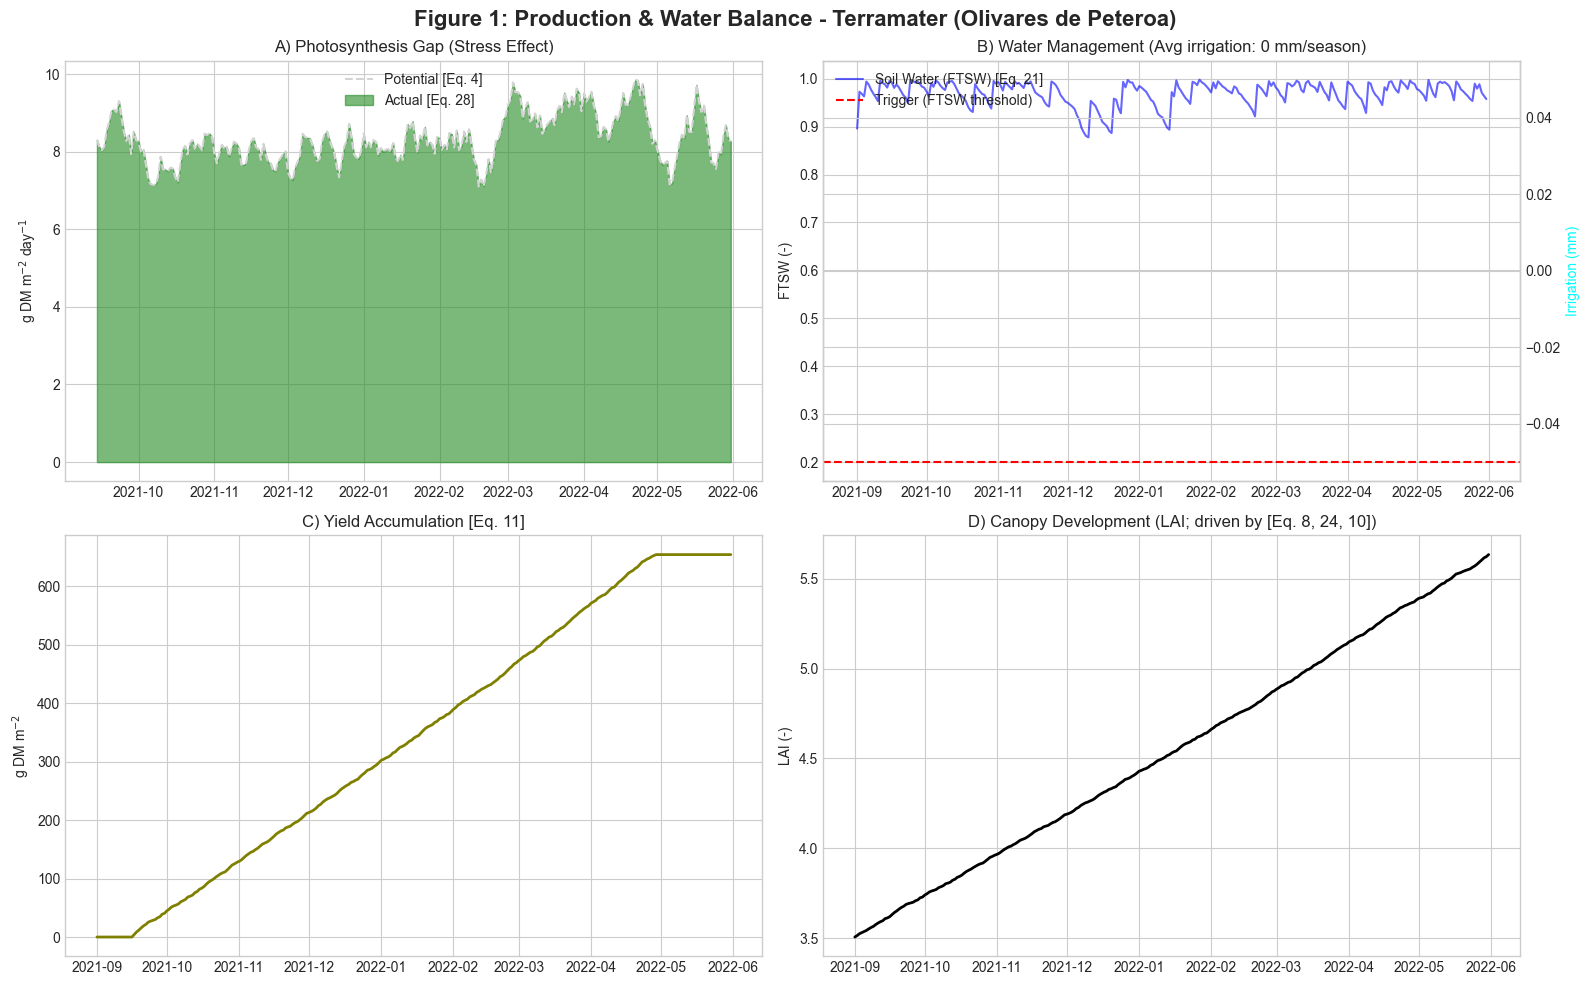

[INFO] Figure 2 saved to: /content/e43d56ba-2fa3-4eec-a743-67e9d66f230e.png


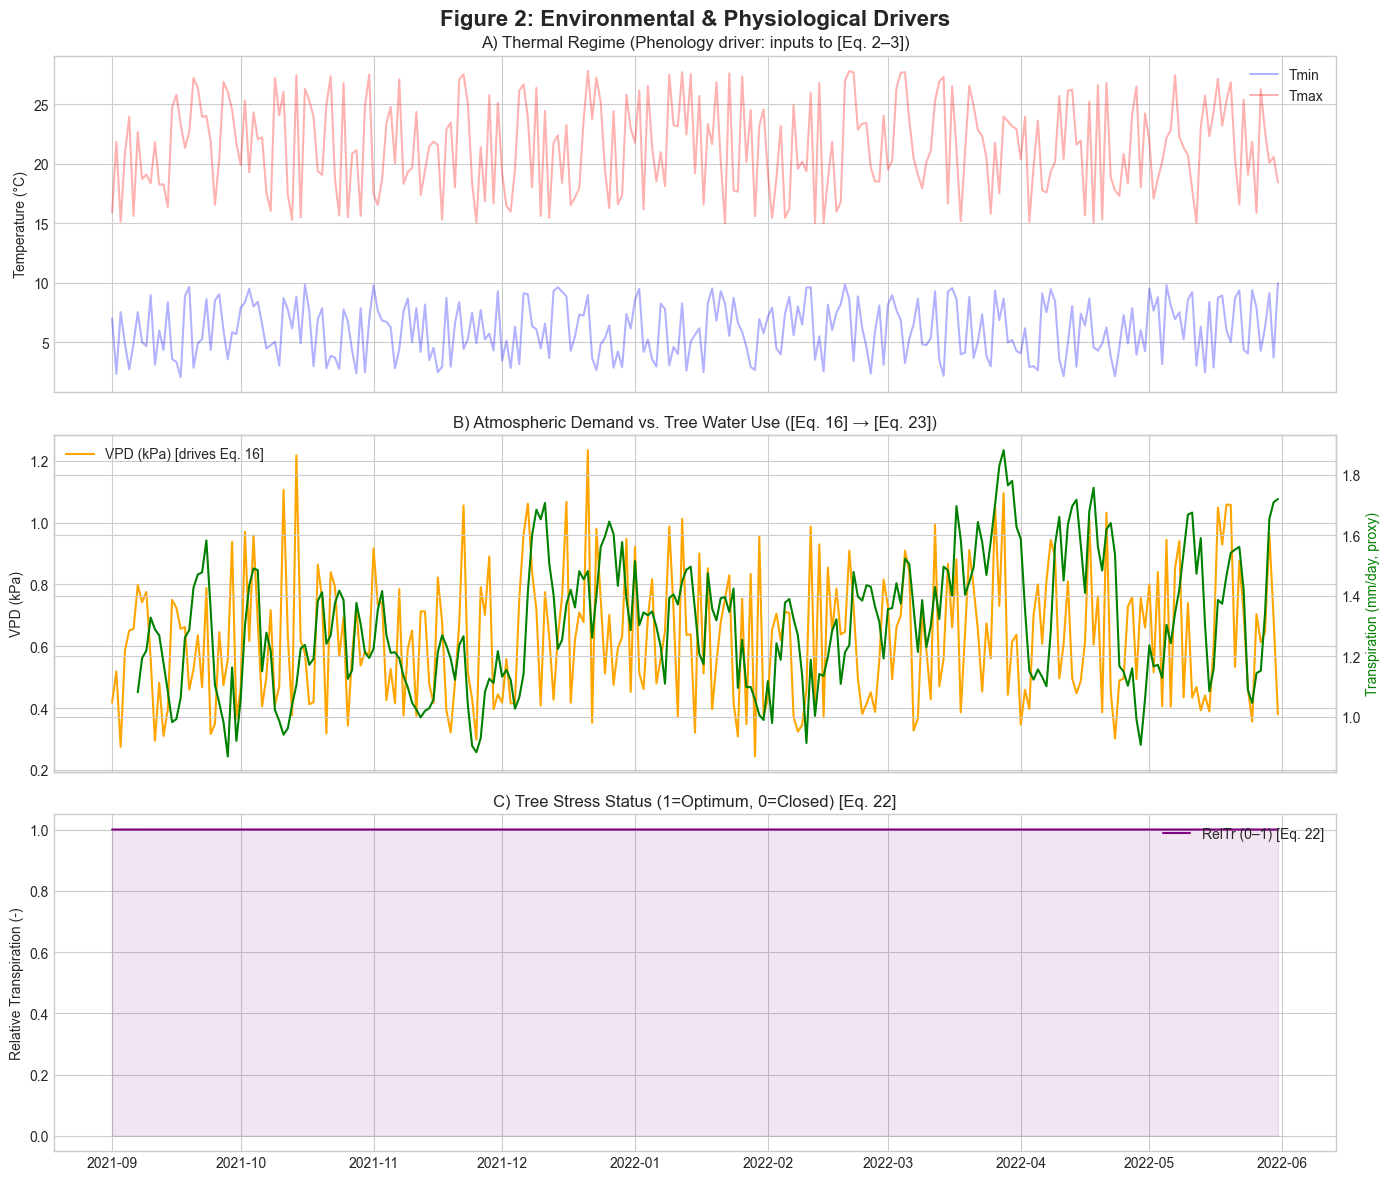

[INFO] Reference image not found: /content/user-MK5DMAfEtw3TnmTHHCU63GkT/2af7fc4e95924e408780e741cd44cb1e/content/table2_page9.png
[INFO] Reference image not found: /content/user-MK5DMAfEtw3TnmTHHCU63GkT/2af7fc4e95924e408780e741cd44cb1e/content/table2_page13.png


In [12]:
# ==========================================================
# OLIVE ORCHARD MODEL (Chile – Terramater / Olivares de Peteroa)
# Full updated script with:
#   (i) One-season Chile subsetting (Southern Hemisphere)
#   (ii) Radiation unit auto-detection (kWh/m²/day vs MJ/m²/day)
#   (iii) Mandatory equation mapping in function comments
#   (iv) Figure 1–2 plotting as functions (using model outputs)
#   (v) Incorporated local paths for your saved figures + reference table images
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt





# Optional: only used to display reference images if available
try:
    from PIL import Image
    _PIL_AVAILABLE = True
except Exception:
    _PIL_AVAILABLE = False


# ==========================================================
# 0. LOCAL PATHS (your current session artifacts + reference tables)
# NOTE: These are session-specific. Keep them for reproducibility in THIS runtime.
#       If running in Colab from scratch, update to your own /content/... paths.
# ==========================================================
FIG1_SAVED_PATH = "/content/70990ce5-1452-40a5-a127-37637ad1296a.png"
FIG2_SAVED_PATH = "/content/e43d56ba-2fa3-4eec-a743-67e9d66f230e.png"

REF_TABLE2_PAGE9_PATH  = "/content/user-MK5DMAfEtw3TnmTHHCU63GkT/2af7fc4e95924e408780e741cd44cb1e/content/table2_page9.png"
REF_TABLE2_PAGE13_PATH = "/content/user-MK5DMAfEtw3TnmTHHCU63GkT/2af7fc4e95924e408780e741cd44cb1e/content/table2_page13.png"

SHOW_REFERENCE_IMAGES = True   # set False if you do not want inline displays
SAVE_FIGURES_TO_PATHS = True   # saves Figure 1 and Figure 2 to FIG1_SAVED_PATH / FIG2_SAVED_PATH


# ==========================================================
# 1. SETUP AND DATA LOADING (Chile-aware + One-Season Ready)
# ==========================================================
DATA_PATH = "/content/datos_nasa/cl_co_power_daily_20190331_20240331.csv"
LOC = "Terramater (Olivares de Peteroa)"
VERBOSE = True

# --- Chile season controls (Southern Hemisphere) ---
# Season definition: Sep 1 (year Y) -> May 31 (year Y+1)
MODEL_ONE_SEASON = True
SEASON_START_YEAR = 2021        # season 2021–2022 (Sep 2021 to May 2022)
SEASON_START_MD = (9, 1)
SEASON_END_MD   = (5, 31)

# If you prefer full multi-year runs, set MODEL_ONE_SEASON=False and use these:
START_DATE, END_DATE = "2020-01-01", "2023-12-31"


# --- Load or create dummy ---
if not os.path.exists(DATA_PATH):
    print(f"[ERROR] File not found: {DATA_PATH}. Generating dummy data.")
    dates = pd.date_range(start="2019-03-31", end="2024-03-31", freq="D")
    df_all = pd.DataFrame({
        "LOCATION": [LOC]*len(dates),
        "T2M_MAX": np.random.uniform(15, 28, len(dates)),
        "T2M_MIN": np.random.uniform(2, 10, len(dates)),
        "ALLSKY_SFC_SW_DWN": np.random.uniform(8, 28, len(dates)),
        "PRECTOTCORR": np.random.choice([0, 0, 0, 15], len(dates)),
        "RH2M": np.random.uniform(40, 80, len(dates))
    }, index=dates)
    df_all.index.name = "DATE"
else:
    df_all = pd.read_csv(DATA_PATH, parse_dates=["DATE"]).set_index("DATE").sort_index()

# --- Filter location ---
if "LOCATION" not in df_all.columns:
    raise ValueError("Expected column 'LOCATION' not found in the input file.")
df_raw = df_all[df_all["LOCATION"] == LOC].copy()

# --- Choose modeling window (one Chile season or multi-year) ---
if MODEL_ONE_SEASON:
    WINDOW_START = pd.Timestamp(SEASON_START_YEAR, SEASON_START_MD[0], SEASON_START_MD[1])
    WINDOW_END   = pd.Timestamp(SEASON_START_YEAR + 1, SEASON_END_MD[0], SEASON_END_MD[1])
    if VERBOSE:
        print(f"[INFO] Chile season subset enabled: {WINDOW_START.date()} -> {WINDOW_END.date()}")
    df = df_raw.loc[(df_raw.index >= WINDOW_START) & (df_raw.index <= WINDOW_END)].copy()
    full_range = pd.date_range(start=WINDOW_START, end=WINDOW_END, freq="D")
else:
    WINDOW_START = pd.Timestamp(START_DATE)
    WINDOW_END   = pd.Timestamp(END_DATE)
    df = df_raw.loc[(df_raw.index >= WINDOW_START) & (df_raw.index <= WINDOW_END)].copy()
    full_range = pd.date_range(start=WINDOW_START, end=WINDOW_END, freq="D")

# --- Safety: enforce daily continuity + conservative interpolation ---
if len(df) == 0:
    raise ValueError(
        "No data after filtering by LOCATION and date window. "
        "Check LOC spelling and your date range vs. file coverage."
    )

missing = full_range.difference(df.index)
if len(missing) > 0:
    print(f"[INFO] Missing {len(missing)} day(s). Reindexing and interpolating (time-based).")
    df = df.reindex(full_range)

    # Interpolate only numeric weather columns; keep LOCATION as LOC
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].interpolate(method="time", limit_direction="both")

    # Restore LOCATION column
    if "LOCATION" in df.columns:
        df["LOCATION"] = LOC

# --- Minimal QC ---
if "RH2M" in df.columns:
    df["RH2M"] = df["RH2M"].clip(lower=0, upper=100)
for col in ["PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

if VERBOSE:
    print(f"[INFO] Final modelling dataframe: {df.index.min().date()} -> {df.index.max().date()} | n={len(df)}")


# ==========================================================
# 2. PARAMETERIZATION (Mapped to Equations / Paper)
# NOTE: For Chile site calibration, tune Eq.(2)–Eq.(3) parameters
#       using observed dormancy release and anthesis dates at Peteroa.
# ==========================================================
params = dict(
    # --- ARCHITECTURE (super-intensive) ---
    PlantD=1600.0,                 # [trees/ha]
    PlantA=10000.0 / 1600.0,        # [m2/tree]
    LAD=2.0,                        # [m2/m3]

    # --- PHENOLOGY MODEL SELECTION ---
    phenology_chill_model="unichill",    # "unichill" (Eq.2) or "triangular_alt"
    phenology_forcing_model="logistic",  # "logistic" (Eq.3) or "gdd_alt"

    # --- Eq. (1) GDH / heat requirement (paper is hourly; daily approximation if used) ---
    tb_budbreak=8.5,                # [°C]

    # --- Eq. (2) UniChill parameters (CALIBRATE for Chile) ---
    chill_a=0.01,
    chill_b=-0.50,
    chill_c=7.20,
    Ccrit=350.0,                    # threshold

    # --- Eq. (3) Forcing Units parameters (CALIBRATE for Chile) ---
    forcing_d=0.50,
    forcing_e=9.00,
    FcritFlo=450.0,                 # threshold

    # --- ALT phenology (NOT Eq. 2–3) ---
    T_opt_chill_alt=7.2,            # [°C]
    T_max_chill_alt=16.0,           # [°C]
    Tb_forcing_alt=9.0,             # [°C]

    # --- GROWTH (Eq. 4–11) ---
    RUE_ol=0.98,                    # [g DM/MJ] (paper text)
    SLA_ol=5.2,                     # [m2/kg]
    HI_pot_base=0.35,               # [-] paper: unstressed HI = 0.35
    harvest_doy=120,                # [DOY] Chile initial guess (calibrate)
    PClf_pot_base=0.18,             # [-] baseline partition coefficient to leaves (proxy)

    # --- CANOPY LIGHT (Eq. 5–7) ---
    Ck1=0.52, Ck2=0.000788, Ck3=0.76, Ck4=1.25,

    # --- SOIL (Eq. 17–21) ---
    TTSW1=70.0,                     # [mm]
    TTSW2=110.0,                    # [mm]
    Initial_Saturation=0.90,         # [-]
    root_frac_layer1=40.0 / 120.0,
    root_frac_layer2=80.0 / 120.0,

    # --- STRESS RESPONSE (Eq. 22) ---
    RelTr_a=6.17,
    RelTr_b=13.45,
    RelLAI_a=78.24,
    RelLAI_b=21.42,

    # --- Eq. (16) Transpiration efficiency ---
    TE_coeff=4.0,                   # Kd (paper uses Pa, VPD in kPa)

    # --- IRRIGATION MANAGEMENT (used in Eq. 18 recharge) ---
    Irrigation_Threshold=0.20,       # trigger when FTSW < threshold
    Irrigation_Efficiency=0.95,

    # --- EVAPORATION (Eq. 32–34) ---
    SALB=0.20,                       # [-]
    gamma_kpa=0.68,                  # [kPa/°C]

    # --- HI stress at anthesis (Eq. 35–36) ---
    FTSWo=0.40,
    FTSWm=0.05,
    TMAXo=30.0,                      # [°C]
    TMAXm=40.0,                      # [°C]
    anthesis_window_days=7,

    # --- OUTPUT CONVERSION ---
    fresh_factor=2.2,                # DM->fresh proxy
)

# Adult orchard initialization (state)
params["LAI_ini"] = 3.5


# ==========================================================
# 3. FUNCTIONS (MANDATORY Equation Mapping)
# ==========================================================

# --------------------------
# [Eq. 1] GDH (paper is hourly; daily approximation only)
# --------------------------
def eq1_gdh_daily(Tavg, tb):
    """[Eq. 1] GDH daily approximation: GDH = max(0, Tavg - tb)."""
    return max(0.0, Tavg - tb)

# --------------------------
# [Eq. 2] UniChill
# --------------------------
def eq2_unichill(Tavg, a, b, c):
    """
    [Eq. 2] Chill Units (UniChill):
      CU = 1/(1 + exp(a*(T-c)^2 + b*(T-c))).
    """
    z = a * (Tavg - c) ** 2 + b * (Tavg - c)
    return 1.0 / (1.0 + np.exp(z))

# --------------------------
# [Eq. 3] Forcing Units (logistic)
# --------------------------
def eq3_forcing_logistic(Tavg, d, e):
    """
    [Eq. 3] Forcing Units:
      FU = 1/(1 + exp(-d*(T-e))).
    """
    z = -d * (Tavg - e)
    return 1.0 / (1.0 + np.exp(z))

# --------------------------
# [ALT] Chill triangular (NOT Eq. 2)
# --------------------------
def alt_chill_triangular(Tmean, Topt, Tmax):
    """[ALT] Triangular chill (NOT Eq. 2)."""
    if Tmean <= 0 or Tmean >= Tmax:
        return 0.0
    return (Tmean / Topt) if Tmean <= Topt else ((Tmax - Tmean) / (Tmax - Topt))

# --------------------------
# [ALT] Forcing via GDD (NOT Eq. 3)
# --------------------------
def alt_forcing_gdd(Tavg, Tb):
    """[ALT] GDD forcing (NOT Eq. 3): max(0, Tavg - Tb)."""
    return max(0.0, Tavg - Tb)

# --------------------------
# [Eq. 6] k'
# --------------------------
def eq6_k_prime(PlantD, LAD, p):
    """
    [Eq. 6] Extinction coefficient:
      k' = Ck1 + Ck2*PlantD - Ck3*exp(-Ck4*LAD).
    """
    return p["Ck1"] + p["Ck2"] * PlantD - p["Ck3"] * np.exp(-p["Ck4"] * LAD)

# --------------------------
# [Eq. 7/9] v from LAI and LAD
# --------------------------
def eq7_v_from_lai(LAI, LAD):
    """
    [Eq. 7/9] Canopy volume per ground area (consistent state derivation):
      v = LAI / LAD  (units: m3/m2).
    """
    return LAI / max(1e-9, LAD)

# --------------------------
# [Eq. 5] Int_OT
# --------------------------
def eq5_int_ot(k_prime, v):
    """
    [Eq. 5] Intercepted radiation fraction:
      Int_OT = 1 - exp(-k' * v).
    """
    return 1.0 - np.exp(-k_prime * v)

# --------------------------
# [Eq. 4] DM potential
# NOTE: Use PAR (MJ/m²/day) as the radiation driver for biomass (common in crop models).
# --------------------------
def eq4_dm_pot(Int_OT, RAD_MJ_for_DM, RUE):
    """
    [Eq. 4] DM_pot = Int_OT * RAD * RUE
    Returns DM_pot in g/m²/day if RAD is MJ/m²/day and RUE is g/MJ.
    """
    return Int_OT * RAD_MJ_for_DM * RUE

# --------------------------
# [Eq. 16] TE
# --------------------------
def eq16_te(Kd_pa, VPD_kpa):
    """
    [Eq. 16] TE = Kd / VPD
    Paper uses Kd in Pa and VPD in kPa.
    """
    return Kd_pa / max(1e-6, VPD_kpa)

# --------------------------
# [Eq. 15] Transpiration potential
# --------------------------
def eq15_tr_pot(DM_pot_gm2, TE):
    """
    [Eq. 15] Tr_pot = DM_pot / TE
    Used consistently as a water-demand proxy.
    """
    return DM_pot_gm2 / max(1e-9, TE)

# --------------------------
# [Eq. 17] TTSW total
# --------------------------
def eq17_ttsw(TTSW1, TTSW2):
    """[Eq. 17] TTSW = TTSW1 + TTSW2."""
    return TTSW1 + TTSW2

# --------------------------
# [Eq. 18–19] Soil recharge (two layers)
# --------------------------
def eq18_19_recharge(ATSW1, ATSW2, Rain, Ir, TTSW1, TTSW2):
    """
    [Eq. 18] ATSW1_t = min(ATSW1_{t-1} + Rain + Ir, TTSW1)
    [Eq. 19] ATSW2_t = min(ATSW2_{t-1} + excess_from_layer1, TTSW2)
    """
    ATSW1_new = ATSW1 + Rain + Ir
    excess = max(0.0, ATSW1_new - TTSW1)
    ATSW1_new = min(ATSW1_new, TTSW1)
    ATSW2_new = min(ATSW2 + excess, TTSW2)
    return ATSW1_new, ATSW2_new

# --------------------------
# [Eq. 20] FTSW1
# --------------------------
def eq20_ftsw1(ATSW1, TTSW1):
    """[Eq. 20] FTSW1 = ATSW1/TTSW1."""
    return ATSW1 / max(1e-9, TTSW1)

# --------------------------
# [Eq. 21] FTSW (whole profile)
# --------------------------
def eq21_ftsw(ATSW1, ATSW2, TTSW1, TTSW2):
    """[Eq. 21] FTSW = (ATSW1+ATSW2)/(TTSW1+TTSW2)."""
    return (ATSW1 + ATSW2) / max(1e-9, (TTSW1 + TTSW2))

# --------------------------
# [Eq. 22] Relative stress factor
# --------------------------
def eq22_rel_factor(FTSW, a, b):
    """[Eq. 22] Rel = 1/(1 + a*exp(-b*FTSW))."""
    return 1.0 / (1.0 + a * np.exp(-b * FTSW))

# --------------------------
# [Eq. 23] Actual transpiration
# --------------------------
def eq23_atr(Tr_pot, RelTr):
    """[Eq. 23] Tr_act = Tr_pot * RelTr."""
    return Tr_pot * RelTr

# --------------------------
# [Eq. 24] Actual leaf-area increment
# --------------------------
def eq24_alai_inc(LAI_inc_pot, RelLAI):
    """[Eq. 24] ALAI_inc = LAI_inc_pot * RelLAI."""
    return LAI_inc_pot * RelLAI

# --------------------------
# [Eq. 27] RelTE
# --------------------------
def eq27_relte(RelTr):
    """[Eq. 27] RelTE = -0.74*RelTr + 1.74."""
    return -0.74 * RelTr + 1.74

# --------------------------
# [Eq. 28] Actual biomass
# --------------------------
def eq28_dm_act(DM_pot, RelTr, RelTE):
    """[Eq. 28] DM_act = DM_pot * RelTr * RelTE."""
    return DM_pot * RelTr * RelTE

# --------------------------
# [Eq. 8] LAI increment from biomass partition to leaves
# --------------------------
def eq8_lai_inc_pot(DM_pot_gm2, PClf_pot, SLA_m2_per_kg):
    """
    [Eq. 8] LAI_inc_pot = (DM_pot * PClf_pot) * SLA
    DM_pot is g/m²/day -> convert to kg/m²/day before SLA.
    """
    DM_leaf_kgm2 = (DM_pot_gm2 * PClf_pot) / 1000.0
    return DM_leaf_kgm2 * SLA_m2_per_kg

# --------------------------
# [Eq. 10] LAI senescence (distributed over DOY window using YLAI_{y-2})
# --------------------------
def eq10_lai_senescence(doy, YLAI_y_minus_2, DOY_ini=250, DOY_end=330):
    """
    [Eq. 10] LAI_sen = YLAI_{y-2}/(DOY_end-DOY_ini+1) within window, else 0.
    NOTE: DOY_ini/DOY_end should be calibrated to olive phenology; kept as placeholders.
    """
    if YLAI_y_minus_2 <= 0:
        return 0.0
    if DOY_ini <= doy <= DOY_end:
        return YLAI_y_minus_2 / float(DOY_end - DOY_ini + 1)
    return 0.0

# --------------------------
# [Eq. 33] Delta (slope of saturation vapour pressure curve)
# --------------------------
def eq33_delta_kpa_per_c(Tavg):
    """[Eq. 33] Delta from Tetens (kPa/°C)."""
    es = 0.6108 * np.exp(17.27 * Tavg / (Tavg + 237.3))
    return 4098.0 * es / ((Tavg + 237.3) ** 2)

# --------------------------
# [Eq. 32] Potential soil evaporation (energy-limited form)
# --------------------------
def eq32_sevp_pot(SRAD_MJ, SALB, INT_tot, Delta, gamma_kpa=0.68, lambda_mj_per_mm=2.45):
    """
    [Eq. 32] SEVP_pot = SRAD*(1-SALB)*(1-INT_tot) * Delta/(Delta+gamma)
    Convert MJ/m² to mm via lambda (2.45 MJ/mm).
    """
    net_rad = SRAD_MJ * (1.0 - SALB) * (1.0 - INT_tot)
    mm_equiv = net_rad / max(1e-9, lambda_mj_per_mm)
    return mm_equiv * (Delta / max(1e-9, (Delta + gamma_kpa)))

# --------------------------
# [Eq. 34] Actual soil evaporation under drying cycle
# --------------------------
def eq34_sevp(sevp_pot, DYSE):
    """[Eq. 34] SEVP = SEVP_pot*(sqrt(DYSE)-sqrt(DYSE-1))."""
    DYSE = max(1.0, float(DYSE))
    return sevp_pot * (np.sqrt(DYSE) - np.sqrt(max(0.0, DYSE - 1.0)))

# --------------------------
# [Eq. 35] HI water-stress at anthesis
# --------------------------
def eq35_hiws(HI_pot, FTSWant, FTSWo=0.40, FTSWm=0.05):
    """
    [Eq. 35] HIws = HI_pot if FTSWant>FTSWo
                  else HI_pot*(1-(FTSWo-FTSWant)/(FTSWo-FTSWm)).
    """
    if FTSWant >= FTSWo:
        return HI_pot
    if FTSWant <= FTSWm:
        return 0.0
    return HI_pot * (1.0 - (FTSWo - FTSWant) / max(1e-9, (FTSWo - FTSWm)))

# --------------------------
# [Eq. 36] HI heat-stress at anthesis
# --------------------------
def eq36_hihs(HI_pot, TMAXant, TMAXo=30.0, TMAXm=40.0):
    """
    [Eq. 36] HIhs = HI_pot if TMAXant<TMAXo
                  else HI_pot*(1-(TMAXant-TMAXo)/(TMAXm-TMAXo)).
    """
    if TMAXant <= TMAXo:
        return HI_pot
    if TMAXant >= TMAXm:
        return 0.0
    return HI_pot * (1.0 - (TMAXant - TMAXo) / max(1e-9, (TMAXm - TMAXo)))

# --------------------------
# [Eq. 11] Yield
# --------------------------
def eq11_yield(HI_actual, DM_cum_gm2):
    """[Eq. 11] Yield_gm2 = HI * DM_cum (up to harvest)."""
    return HI_actual * DM_cum_gm2

# --------------------------
# [Eq. 37–40] Alternate bearing updates (apply at season boundary)
# --------------------------
def eq37_40_update_next_season(HIa, HI_pot_base=0.35, PClf_pot_base=0.18):
    """
    [Eq. 37–40] Unified forms (paper-derived):
      HI_pot_next = 0.70 - HIa      (clamped)
      PClf_next   = PClf_base*(0.65 + HIa)
    """
    HI_pot_next = max(0.0, min(0.70, 0.70 - HIa))
    PClf_next = max(0.0, PClf_pot_base * (0.65 + HIa))
    return HI_pot_next, PClf_next

# --------------------------
# [Eq. 41] Alternate Bearing Index (ABI)
# --------------------------
def eq41_abi(yields):
    """[Eq. 41] ABI = (1/(n-1)) * sum(|Yi - Yi+1|/(Yi + Yi+1))."""
    ys = [y for y in yields if y is not None and not np.isnan(y)]
    n = len(ys)
    if n < 2:
        return np.nan
    terms = []
    for i in range(n - 1):
        denom = ys[i] + ys[i + 1]
        terms.append(abs(ys[i] - ys[i + 1]) / denom if denom > 0 else 0.0)
    return sum(terms) / (n - 1)


# ==========================================================
# 4. PRE-PROCESSING (Mapped variables)
# NASA POWER daily columns assumed:
#   T2M_MAX, T2M_MIN, ALLSKY_SFC_SW_DWN, RH2M, PRECTOTCORR
# ==========================================================
df = df.copy()
df["TAVG"] = (df["T2M_MAX"] + df["T2M_MIN"]) / 2.0

# --- Radiation unit detection for ALLSKY_SFC_SW_DWN ---
# Heuristic:
#   - kWh/m²/day typically ~ 2–9
#   - MJ/m²/day typically ~ 10–30
allsky_mean = float(df["ALLSKY_SFC_SW_DWN"].mean())
if allsky_mean < 12.0:
    rad_factor = 3.6
    if VERBOSE:
        print("[INFO] Radiation units: kWh/m²/day detected (×3.6 -> MJ/m²/day)")
else:
    rad_factor = 1.0
    if VERBOSE:
        print("[INFO] Radiation units: MJ/m²/day detected (×1.0)")

df["SRAD_MJ"] = df["ALLSKY_SFC_SW_DWN"] * rad_factor          # for [Eq. 32] (energy)
df["PAR_MJ"]  = df["SRAD_MJ"] * 0.48                          # for [Eq. 4] (biomass driver)

if VERBOSE:
    print(f"[INFO] Mean ALLSKY={allsky_mean:.2f} | Mean SRAD_MJ={df['SRAD_MJ'].mean():.2f} | Mean RAD_MJ(PAR)={df['PAR_MJ'].mean():.2f}")

# --- VPD (kPa) for [Eq. 16] (Tetens; uses TAVG and RH2M) ---
es = 0.6108 * np.exp(17.27 * df["TAVG"] / (df["TAVG"] + 237.3))
ea = es * (df["RH2M"] / 100.0)
df["VPD_kPa"] = np.maximum(0.1, es - ea)

# --- Rain (mm) for [Eq. 18] ---
df["RAIN_mm"] = df["PRECTOTCORR"]


# ==========================================================
# 5. SIMULATION LOOP (Chile-consistent season handling)
# Season year definition: Southern Hemisphere Jul–Jun
#   season_year = year if month >= 7 else year - 1
# ==========================================================
LAI = params["LAI_ini"]
ATSW1 = params["TTSW1"] * params["Initial_Saturation"]
ATSW2 = params["TTSW2"] * params["Initial_Saturation"]
DYSE = 1

# Phenology accumulators (per season)
chill_cum = 0.0
forcing_cum = 0.0
dormancy_released = False
anthesis_occurred = False
anthesis_date = None

# HI state (per season)
HI_pot = params["HI_pot_base"]
HIa = HI_pot
HIa_fixed = False
anthesis_FTSW_samples = []
anthesis_TMAX_samples = []

# Biomass accumulation for [Eq. 11] (per season; stops at harvest)
DM_cum = 0.0

# Alternate bearing / memory across seasons
year_state = dict(
    YLAI_prod_by_season={},
    HIa_by_season={},
    yield_by_season={},
)
YLAI_produced_this_season = 0.0

results = []

print(f"--- STARTING SIMULATION: {LOC} ---")
print(f"Date window: {df.index.min().date()} to {df.index.max().date()}")
print(f"Strategy: Irrigation Threshold = {params['Irrigation_Threshold']:.2f} (FTSW)")
print(f"Harvest DOY (Chile init): {params['harvest_doy']}  (calibrate with farm records)")
print(f"Phenology models: Chill={params['phenology_chill_model']} | Forcing={params['phenology_forcing_model']}")

for date, row in df.iterrows():
    year = int(date.year)
    doy = int(date.dayofyear)
    season_year = year if date.month >= 7 else year - 1

    # ------------------------------------------------------
    # SEASON RESET at July 1 (Southern Hemisphere)
    # ------------------------------------------------------
    if (date.month == 7) and (date.day == 1):
        prev_season = season_year - 1

        if prev_season not in year_state["YLAI_prod_by_season"]:
            year_state["YLAI_prod_by_season"][prev_season] = YLAI_produced_this_season
        YLAI_produced_this_season = 0.0

        prev_HIa = year_state["HIa_by_season"].get(prev_season, params["HI_pot_base"])
        HI_pot, PClf_next = eq37_40_update_next_season(
            prev_HIa, HI_pot_base=params["HI_pot_base"], PClf_pot_base=params["PClf_pot_base"]
        )
        params["PClf_pot_base"] = PClf_next

        chill_cum = 0.0
        forcing_cum = 0.0
        dormancy_released = False
        anthesis_occurred = False
        anthesis_date = None
        HIa = HI_pot
        HIa_fixed = False
        anthesis_FTSW_samples = []
        anthesis_TMAX_samples = []
        DM_cum = 0.0
        DYSE = 1

        if VERBOSE:
            print(f"\n--- SEASON {season_year}-{season_year+1} RESET (Jul 1) ---")
            print(f"    HI_pot updated [Eq.37–40] -> {HI_pot:.3f} | PClf_pot -> {params['PClf_pot_base']:.3f}")

    # ------------------------------------------------------
    # PHENOLOGY: Eq. (2) and Eq. (3) with daily TAVG
    # IMPORTANT: Eq.(2)-(3) are hourly in the paper; using daily TAVG
    # we scale by 24 to approximate hourly integration magnitudes.
    # ------------------------------------------------------
    Tavg = float(row["TAVG"])

    if not dormancy_released:
        if params["phenology_chill_model"] == "unichill":
            CU = eq2_unichill(Tavg, params["chill_a"], params["chill_b"], params["chill_c"])  # [Eq. 2]
            chill_cum += CU * 24.0
        else:
            CU_alt = alt_chill_triangular(Tavg, params["T_opt_chill_alt"], params["T_max_chill_alt"])
            chill_cum += CU_alt * 24.0

        if chill_cum >= params["Ccrit"]:
            dormancy_released = True
            if VERBOSE:
                print(f"[PHENO] {date.date()} dormancy released | chill_cum={chill_cum:.1f}")

    elif not anthesis_occurred:
        if params["phenology_forcing_model"] == "logistic":
            FU = eq3_forcing_logistic(Tavg, params["forcing_d"], params["forcing_e"])          # [Eq. 3]
            forcing_cum += FU * 24.0
        else:
            forcing_cum += alt_forcing_gdd(Tavg, params["Tb_forcing_alt"])

        if forcing_cum >= params["FcritFlo"]:
            anthesis_occurred = True
            anthesis_date = date
            if VERBOSE:
                print(f"[PHENO] {date.date()} anthesis reached")

    # ------------------------------------------------------
    # CANOPY / LIGHT: Eq. (6) -> Eq. (7/9) -> Eq. (5)
    # ------------------------------------------------------
    k_prime = eq6_k_prime(params["PlantD"], params["LAD"], params)   # [Eq. 6]
    v = eq7_v_from_lai(LAI, params["LAD"])                           # [Eq. 7/9]
    Int_OT = eq5_int_ot(k_prime, v)                                  # [Eq. 5]

    # ------------------------------------------------------
    # POTENTIAL GROWTH: Eq. (4) using PAR_MJ as radiation input
    # ------------------------------------------------------
    PAR_MJ = float(row["PAR_MJ"])
    DM_pot = eq4_dm_pot(Int_OT, PAR_MJ, params["RUE_ol"])            # [Eq. 4]

    # ------------------------------------------------------
    # IRRIGATION + SOIL RECHARGE: Eq. (18–19), status Eq. (20–21)
    # ------------------------------------------------------
    total_capacity = eq17_ttsw(params["TTSW1"], params["TTSW2"])      # [Eq. 17]
    current_FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])  # [Eq. 21]

    irrigation_today = 0.0
    if (current_FTSW < params["Irrigation_Threshold"]) and (date.month in [9, 10, 11, 12, 1, 2, 3, 4]):
        deficit = total_capacity - (ATSW1 + ATSW2)
        irrigation_today = deficit / max(1e-9, params["Irrigation_Efficiency"])

    Rain = float(row["RAIN_mm"])
    Ir = float(irrigation_today)

    ATSW1, ATSW2 = eq18_19_recharge(ATSW1, ATSW2, Rain, Ir, params["TTSW1"], params["TTSW2"])  # [Eq. 18–19]

    FTSW1 = eq20_ftsw1(ATSW1, params["TTSW1"])                       # [Eq. 20]
    FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"]) # [Eq. 21]

    # ------------------------------------------------------
    # STRESS: Eq. (22), Eq. (27), Eq. (28)
    # ------------------------------------------------------
    RelTr = eq22_rel_factor(FTSW, params["RelTr_a"], params["RelTr_b"])        # [Eq. 22]
    RelLAI = eq22_rel_factor(FTSW, params["RelLAI_a"], params["RelLAI_b"])     # [Eq. 22]
    RelTE = eq27_relte(RelTr)                                                  # [Eq. 27]
    DM_act = eq28_dm_act(DM_pot, RelTr, RelTE)                                 # [Eq. 28]

    # ------------------------------------------------------
    # TRANSPIRATION: Eq. (16) -> Eq. (15) -> Eq. (23)
    # ------------------------------------------------------
    VPD_kPa = float(row["VPD_kPa"])
    TE = eq16_te(params["TE_coeff"], VPD_kPa)                                  # [Eq. 16]
    Tr_pot = eq15_tr_pot(DM_pot, TE)                                           # [Eq. 15]
    Tr_act = eq23_atr(Tr_pot, RelTr)                                           # [Eq. 23]

    # ------------------------------------------------------
    # SOIL EVAPORATION: Eq. (32–34) uses SRAD_MJ (total energy, not PAR)
    # ------------------------------------------------------
    if (Rain + Ir) > 0.5:
        DYSE = 1
    else:
        DYSE += 1

    SRAD_MJ = float(row["SRAD_MJ"])
    Delta = eq33_delta_kpa_per_c(Tavg)                                         # [Eq. 33]
    SEVP_pot = eq32_sevp_pot(SRAD_MJ, params["SALB"], Int_OT, Delta, params["gamma_kpa"])  # [Eq. 32]
    SEVP = eq34_sevp(SEVP_pot, DYSE)                                           # [Eq. 34]

    # ------------------------------------------------------
    # WATER UPTAKE: Eq. (30–31) operationalized via root fractions
    # ------------------------------------------------------
    Tr1 = Tr_act * params["root_frac_layer1"]
    Tr2 = Tr_act * params["root_frac_layer2"]

    ATSW1 -= (Tr1 + SEVP)
    if ATSW1 < 0:
        deficit = -ATSW1
        ATSW1 = 0.0
        ATSW2 = max(0.0, ATSW2 - deficit)

    ATSW2 = max(0.0, ATSW2 - Tr2)

    FTSW1 = eq20_ftsw1(ATSW1, params["TTSW1"])                                  # [Eq. 20]
    FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])            # [Eq. 21]

    # ------------------------------------------------------
    # HI AT ANTHESIS: Eq. (35–36), additive HIa rule
    # ------------------------------------------------------
    if anthesis_occurred and (not HIa_fixed):
        anthesis_FTSW_samples.append(FTSW)
        anthesis_TMAX_samples.append(float(row["T2M_MAX"]))

        if len(anthesis_FTSW_samples) >= params["anthesis_window_days"]:
            FTSWant = float(np.mean(anthesis_FTSW_samples))
            TMAXant = float(np.mean(anthesis_TMAX_samples))

            HIws = eq35_hiws(HI_pot, FTSWant, params["FTSWo"], params["FTSWm"])  # [Eq. 35]
            HIhs = eq36_hihs(HI_pot, TMAXant, params["TMAXo"], params["TMAXm"])  # [Eq. 36]

            HIa = max(0.0, min(HI_pot, HIws + HIhs - HI_pot))
            HIa_fixed = True

            year_state["HIa_by_season"][season_year] = HIa

            if VERBOSE:
                print(f"[HI] {date.date()} HIa fixed | HIws={HIws:.3f}, HIhs={HIhs:.3f}, HIa={HIa:.3f}")

    # ------------------------------------------------------
    # LEAF GROWTH: Eq. (8) + Eq. (24); Senescence Eq. (10); LAI update
    # ------------------------------------------------------
    PClf_pot = params["PClf_pot_base"]

    LAI_inc_pot = eq8_lai_inc_pot(DM_pot, PClf_pot, params["SLA_ol"])          # [Eq. 8]
    ALAI_inc = eq24_alai_inc(LAI_inc_pot, RelLAI)                               # [Eq. 24]

    if ALAI_inc > 0:
        YLAI_produced_this_season += ALAI_inc

    YLAI_y_minus_2 = year_state["YLAI_prod_by_season"].get(season_year - 2, 0.0)
    LAI_sen = eq10_lai_senescence(doy, YLAI_y_minus_2)                          # [Eq. 10]

    LAI = max(0.1, LAI + ALAI_inc - LAI_sen)

    # ------------------------------------------------------
    # YIELD ACCUMULATION: Eq. (11), STOP at harvest DOY
    # ------------------------------------------------------
    harvest_passed = (date.month <= 6) and (doy >= int(params["harvest_doy"]))

    if dormancy_released and (not harvest_passed):
        DM_cum += DM_act

    yield_gm2 = eq11_yield(HIa if HIa_fixed else HI_pot, DM_cum)                # [Eq. 11]

    results.append(
        dict(
            DATE=date,
            SEASON_YEAR=season_year,
            DOY=doy,
            LAI=LAI,
            v=v,
            k_prime=k_prime,
            Int_OT=Int_OT,
            DM_pot=DM_pot,
            DM_act=DM_act,
            DM_cum=DM_cum,
            HI_pot=HI_pot,
            HIa=HIa if HIa_fixed else np.nan,
            Yield_gm2=yield_gm2,
            ATSW1=ATSW1,
            ATSW2=ATSW2,
            FTSW1=FTSW1,
            FTSW=FTSW,
            RelTr=RelTr,
            RelLAI=RelLAI,
            RelTE=RelTE,
            TE=TE,
            Tr_pot=Tr_pot,
            Tr_act=Tr_act,
            SEVP_pot=SEVP_pot,
            SEVP=SEVP,
            DYSE=DYSE,
            Rain=Rain,
            Irrigation=Ir,
            VPD_kPa=VPD_kPa,
            dormancy_released=dormancy_released,
            anthesis_occurred=anthesis_occurred,
            harvest_passed=harvest_passed,
        )
    )


# ==========================================================
# 6. RESULTS & AUDIT (Chile-consistent: group by SEASON_YEAR)
# Includes ABI [Eq. 41]
# ==========================================================
res_df = pd.DataFrame(results).set_index("DATE")

seasonal_yield_gm2 = res_df.groupby("SEASON_YEAR")["Yield_gm2"].max()
seasonal_yield_kg_ha_dm = seasonal_yield_gm2 * 10.0
seasonal_yield_kg_ha_fresh = seasonal_yield_kg_ha_dm * params["fresh_factor"]

seasonal_irrig_mm = res_df.groupby("SEASON_YEAR")["Irrigation"].sum()

abi = eq41_abi([seasonal_yield_kg_ha_dm.loc[s] for s in seasonal_yield_kg_ha_dm.index])

# With one season, ABI will be NaN by definition; keep behavior explicit.
if len(seasonal_yield_kg_ha_dm) >= 3:
    core_seasons = seasonal_yield_kg_ha_dm.index[1:-1]
    avg_yield_dm = seasonal_yield_kg_ha_dm.loc[core_seasons].mean()
    avg_yield_fresh = seasonal_yield_kg_ha_fresh.loc[core_seasons].mean()
    avg_irrig = seasonal_irrig_mm.loc[core_seasons].mean()
else:
    avg_yield_dm = seasonal_yield_kg_ha_dm.mean()
    avg_yield_fresh = seasonal_yield_kg_ha_fresh.mean()
    avg_irrig = seasonal_irrig_mm.mean()

print("\n" + "=" * 80)
print(f"FINAL AUDIT (Chile) | LOC={LOC}")
print("=" * 80)
print(f"Seasons evaluated (SEASON_YEAR): {list(seasonal_yield_kg_ha_dm.index)}")
print(f"Phenology models: Chill={params['phenology_chill_model']} | Forcing={params['phenology_forcing_model']}")
print(f"Harvest DOY: {params['harvest_doy']}  | Irrigation threshold FTSW={params['Irrigation_Threshold']:.2f}")
print("-" * 80)
print(f"Average Yield (DM):      {avg_yield_dm:.0f} kg/ha")
print(f"Average Yield (Fresh*):  {avg_yield_fresh:.0f} kg/ha   (*fresh_factor={params['fresh_factor']})")
print(f"Average Irrigation:      {avg_irrig:.0f} mm/season-year")
print(f"Alternate Bearing Index: {abi:.3f}   [Eq. 41]")
print("-" * 80)

if avg_yield_fresh > 12000:
    print("STATUS: Commercial super-intensive yield range (fresh basis).")
elif avg_yield_fresh > 5000:
    print("STATUS: Moderate yield range (fresh basis).")
else:
    print("STATUS: Low yield; calibrate Eq. (2–3) using observed anthesis dates and confirm harvest DOY for Peteroa.")


# ==========================================================
# 7. VISUALIZATION (FIGURES) - as functions using model outputs
# ==========================================================
def plot_figures_chile(df_weather, res_df, params, LOC, avg_irrig_mm, save_figs=True):
    """
    Generates:
      Figure 1: Production & Water Balance
      Figure 2: Environmental & Physiological Drivers

    Expected columns:
      df_weather: T2M_MAX, T2M_MIN
      res_df: DM_pot, DM_act, FTSW, Irrigation, Yield_gm2, LAI, VPD_kPa, Tr_act, RelTr
    """

    plt.style.use("seaborn-v0_8-whitegrid")

    # -------------------------
    # FIGURE 1
    # -------------------------
    fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig1.suptitle(f"Figure 1: Production & Water Balance - {LOC}", fontsize=16, fontweight="bold")

    # A) Biomass Gap
    ax1 = axes[0, 0]
    ax1.plot(res_df.index, res_df["DM_pot"].rolling(14).mean(), color="lightgray", ls="--", label="Potential [Eq. 4]")
    ax1.fill_between(res_df.index, res_df["DM_act"].rolling(14).mean(), color="forestgreen", alpha=0.6, label="Actual [Eq. 28]")
    ax1.set_title("A) Photosynthesis Gap (Stress Effect)", fontsize=12)
    ax1.set_ylabel("g DM m$^{-2}$ day$^{-1}$")
    ax1.legend()

    # B) Irrigation & Soil Water
    ax2 = axes[0, 1]
    ax2.plot(res_df.index, res_df["FTSW"], color="blue", alpha=0.6, label="Soil Water (FTSW) [Eq. 21]")
    ax2.axhline(params["Irrigation_Threshold"], color="red", ls="--", label="Trigger (FTSW threshold)")
    ax2_bis = ax2.twinx()
    ax2_bis.bar(res_df.index, res_df["Irrigation"], color="cyan", alpha=0.5, width=2, label="Irrigation (mm)")
    ax2_bis.set_ylabel("Irrigation (mm)", color="cyan")
    ax2.set_title(f"B) Water Management (Avg irrigation: {avg_irrig_mm:.0f} mm/season)", fontsize=12)
    ax2.set_ylabel("FTSW (-)")
    ax2.legend(loc="upper left")

    # C) Yield Accumulation
    ax3 = axes[1, 0]
    ax3.plot(res_df.index, res_df["Yield_gm2"], color="olive", lw=2)
    ax3.set_title("C) Yield Accumulation [Eq. 11]", fontsize=12)
    ax3.set_ylabel("g DM m$^{-2}$")

    # D) Canopy Structure
    ax4 = axes[1, 1]
    ax4.plot(res_df.index, res_df["LAI"], color="black", lw=2)
    ax4.set_title("D) Canopy Development (LAI; driven by [Eq. 8, 24, 10])", fontsize=12)
    ax4.set_ylabel("LAI (-)")

    plt.tight_layout()
    if save_figs and SAVE_FIGURES_TO_PATHS:
        fig1.savefig(FIG1_SAVED_PATH, dpi=200, bbox_inches="tight")
        if VERBOSE:
            print(f"[INFO] Figure 1 saved to: {FIG1_SAVED_PATH}")
    plt.show()

    # -------------------------
    # FIGURE 2
    # -------------------------
    fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    fig2.suptitle("Figure 2: Environmental & Physiological Drivers", fontsize=16, fontweight="bold")

    # A) Temperature & Phenology driver inputs
    ax_temp = axes2[0]
    ax_temp.plot(df_weather.index, df_weather["T2M_MIN"], color="blue", alpha=0.3, label="Tmin")
    ax_temp.plot(df_weather.index, df_weather["T2M_MAX"], color="red", alpha=0.3, label="Tmax")
    ax_temp.set_ylabel("Temperature (°C)")
    ax_temp.legend(loc="upper right")
    ax_temp.set_title("A) Thermal Regime (Phenology driver: inputs to [Eq. 2–3])", fontsize=12)

    # B) Atmospheric demand (VPD) vs transpiration
    ax_vpd = axes2[1]
    ax_vpd.plot(res_df.index, res_df["VPD_kPa"], color="orange", label="VPD (kPa) [drives Eq. 16]")
    ax_vpd_bis = ax_vpd.twinx()
    ax_vpd_bis.plot(res_df.index, res_df["Tr_act"].rolling(7).mean(), color="green", lw=1.5, label="Transpiration (proxy) [Eq. 23]")
    ax_vpd_bis.set_ylabel("Transpiration (mm/day, proxy)", color="green")
    ax_vpd.set_ylabel("VPD (kPa)")
    ax_vpd.legend(loc="upper left")
    ax_vpd.set_title("B) Atmospheric Demand vs. Tree Water Use ([Eq. 16] → [Eq. 23])", fontsize=12)

    # C) Physiological status (stress)
    ax_phys = axes2[2]
    ax_phys.plot(res_df.index, res_df["RelTr"], color="purple", lw=1.5, label="RelTr (0–1) [Eq. 22]")
    ax_phys.fill_between(res_df.index, res_df["RelTr"], 0, color="purple", alpha=0.1)
    ax_phys.set_ylabel("Relative Transpiration (-)")
    ax_phys.set_title("C) Tree Stress Status (1=Optimum, 0=Closed) [Eq. 22]", fontsize=12)
    ax_phys.legend(loc="upper right")

    plt.tight_layout()
    if save_figs and SAVE_FIGURES_TO_PATHS:
        fig2.savefig(FIG2_SAVED_PATH, dpi=200, bbox_inches="tight")
        if VERBOSE:
            print(f"[INFO] Figure 2 saved to: {FIG2_SAVED_PATH}")
    plt.show()


def _show_image_if_available(path, title=None):
    """Utility: display an image from a local path, if available."""
    if not SHOW_REFERENCE_IMAGES:
        return
    if not os.path.exists(path):
        print(f"[INFO] Reference image not found: {path}")
        return
    if not _PIL_AVAILABLE:
        print(f"[INFO] PIL not available; cannot display image: {path}")
        return

    img = Image.open(path)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# --- Run plots ---
plot_figures_chile(df, res_df, params, LOC, avg_irrig, save_figs=True)

# --- Optional: show your reference table images (paths incorporated above) ---
_show_image_if_available(REF_TABLE2_PAGE9_PATH,  title="Reference: Table 2 (Page 9)")
_show_image_if_available(REF_TABLE2_PAGE13_PATH, title="Reference: Table 2 (Page 13)")


## Yearly

[ERROR] File not found: /content/datos_nasa/cl_co_power_daily_20190331_20240331.csv. Generating dummy data.
[INFO] Modelling dataframe: 2019-03-31 -> 2024-03-31 | n=1828
[INFO] Radiation units likely MJ/m²/day; keeping (×1.0).
[INFO] Mean ALLSKY=17.86 | Mean SRAD_MJ=17.86 | Mean PAR_MJ=8.57

--- STARTING SIMULATION: Terramater (Olivares de Peteroa) ---
Date window: 2019-03-31 to 2024-03-31
Season definition: (9, 1) -> (5, 31) (Sep->May)
Irrigation trigger: FTSW < 0.20
Harvest DOY: 120 (calibrate if needed)

[PHENO] 2019-04-08 dormancy released
[PHENO] 2019-04-30 anthesis reached
[HI] 2019-05-06 HIa fixed | HIa=0.350
--- SEASON 2019-2020 RESET (Sep 1) ---
    HI_pot=0.350 | PClf_pot=0.180
[PHENO] 2019-09-09 dormancy released
[PHENO] 2019-09-30 anthesis reached
[HI] 2019-10-06 HIa fixed | HIa=0.350
--- SEASON 2020-2021 RESET (Sep 1) ---
    HI_pot=0.350 | PClf_pot=0.180
[PHENO] 2020-09-09 dormancy released
[PHENO] 2020-10-01 anthesis reached
[HI] 2020-10-07 HIa fixed | HIa=0.350
--- SEAS

C:\Users\fperezg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[INFO] Saved: /content/FIG1_multiseason_CI.png


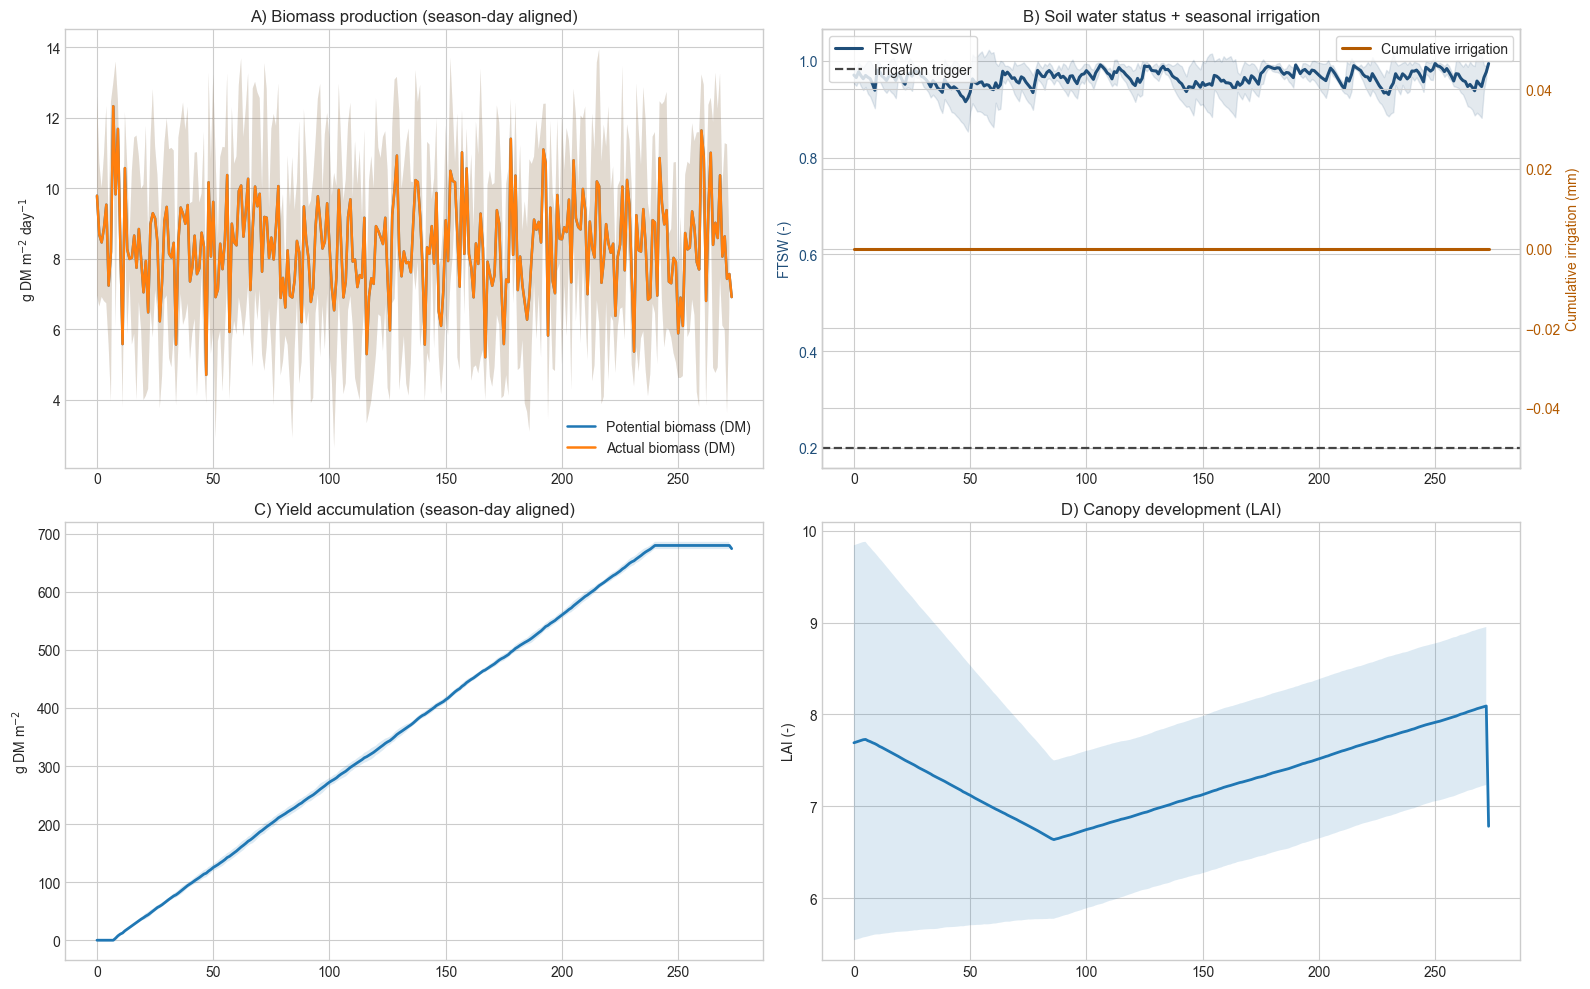

[INFO] Saved: /content/FIG2_multiseason_CI.png


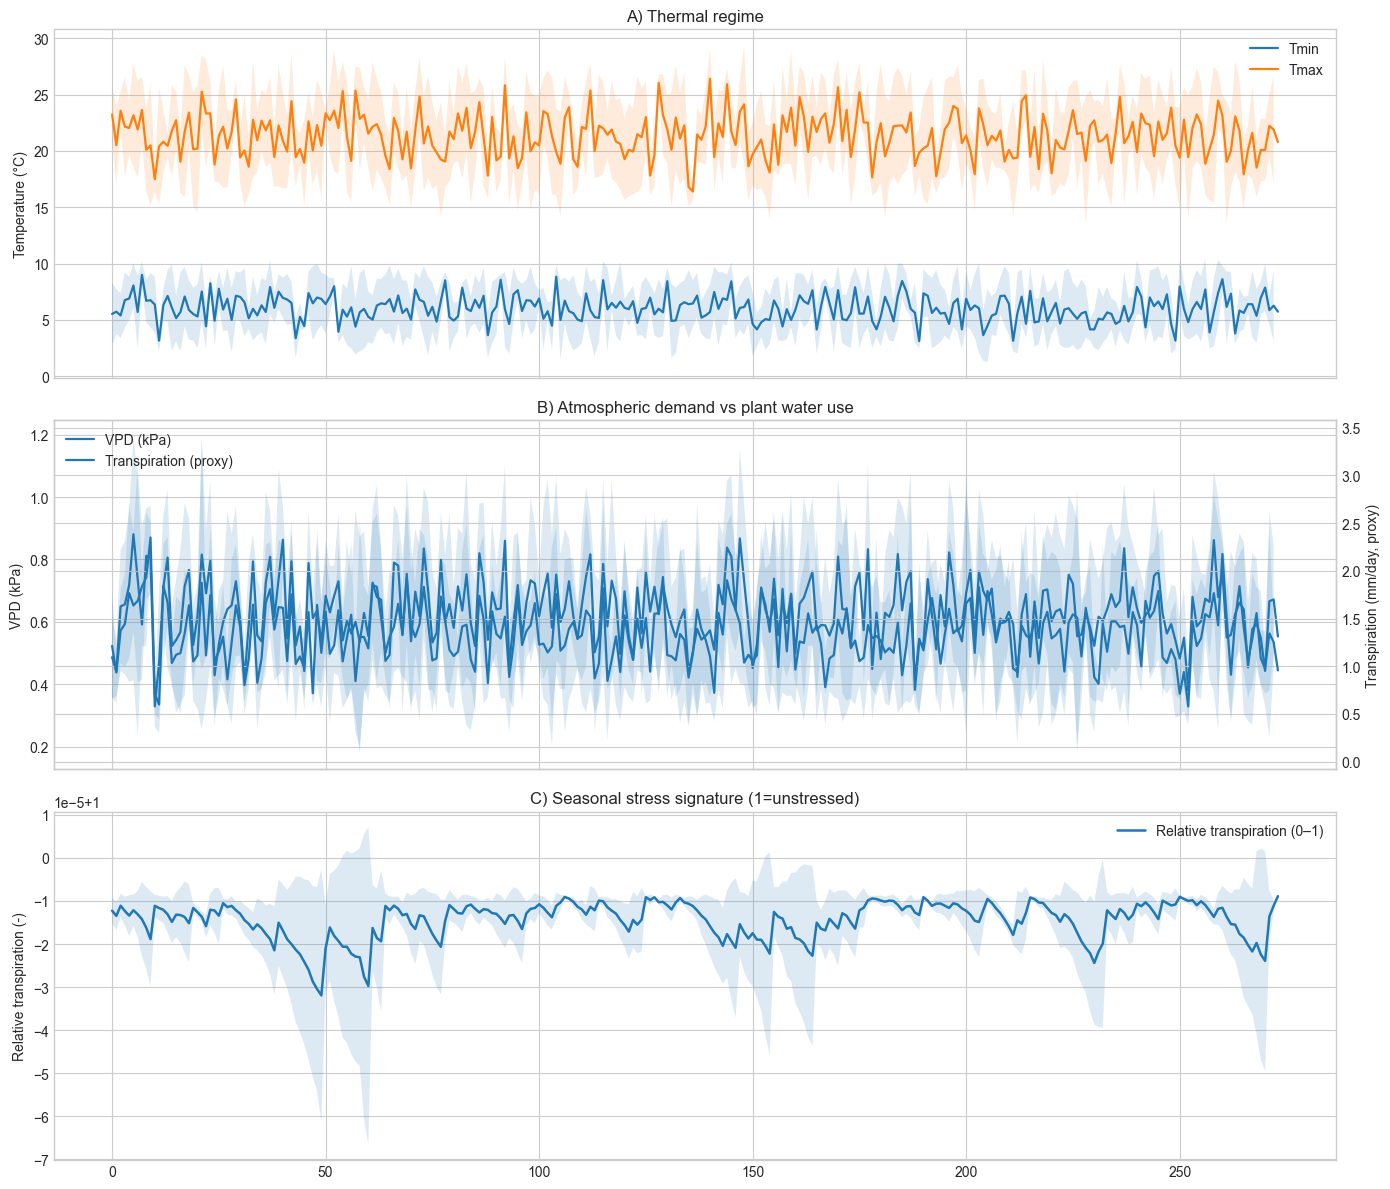

In [13]:
# ==========================================================
# OLIVE ORCHARD MODEL (Chile – Terramater / Olivares de Peteroa)
# Multi-season version (Sep 1 -> May 31)
# - Runs all available seasons in the selected date window
# - Builds a season synthesis table
# - Plots multi-season mean ± 95% CI (season-day aligned)
# ==========================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# 0) CONFIG
# ==========================================================
DATA_PATH = "/content/datos_nasa/cl_co_power_daily_20190331_20240331.csv"
LOC = "Terramater (Olivares de Peteroa)"

# Use the full multi-year coverage (adjust if you want)
START_DATE, END_DATE = "2019-03-31", "2024-03-31"

# Chile agronomic season definition
SEASON_START_MD = (9, 1)   # Sep 1
SEASON_END_MD   = (5, 31)  # May 31 (next year)

VERBOSE = True

# Outputs
OUT_TABLE_PATH = "/content/chile_multiseason_synthesis.csv"
FIG1_PATH = "/content/FIG1_multiseason_CI.png"
FIG2_PATH = "/content/FIG2_multiseason_CI.png"

SAVE_FIGS = True


# ==========================================================
# 1) LOAD DATA
# ==========================================================
if not os.path.exists(DATA_PATH):
    print(f"[ERROR] File not found: {DATA_PATH}. Generating dummy data.")
    dates = pd.date_range(start=START_DATE, end=END_DATE, freq="D")
    df_all = pd.DataFrame({
        "DATE": dates,
        "LOCATION": [LOC]*len(dates),
        "T2M_MAX": np.random.uniform(15, 28, len(dates)),
        "T2M_MIN": np.random.uniform(2, 10, len(dates)),
        "ALLSKY_SFC_SW_DWN": np.random.uniform(8, 28, len(dates)),
        "PRECTOTCORR": np.random.choice([0, 0, 0, 15], len(dates)),
        "RH2M": np.random.uniform(40, 80, len(dates))
    })
else:
    df_all = pd.read_csv(DATA_PATH, parse_dates=["DATE"])

df_all = df_all.sort_values("DATE").set_index("DATE")

if "LOCATION" not in df_all.columns:
    raise ValueError("Expected column 'LOCATION' not found in the input file.")

df_raw = df_all[df_all["LOCATION"] == LOC].copy()
if len(df_raw) == 0:
    raise ValueError("No rows for LOC. Check LOC spelling vs. file.")

WINDOW_START = pd.Timestamp(START_DATE)
WINDOW_END   = pd.Timestamp(END_DATE)
df = df_raw.loc[(df_raw.index >= WINDOW_START) & (df_raw.index <= WINDOW_END)].copy()
if len(df) == 0:
    raise ValueError("No data after date filtering. Check START_DATE/END_DATE vs. file coverage.")

# Enforce daily continuity (conservative interpolation for numeric columns)
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
missing = full_range.difference(df.index)
if len(missing) > 0:
    if VERBOSE:
        print(f"[INFO] Missing {len(missing)} day(s). Reindexing and interpolating.")
    df = df.reindex(full_range)
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].interpolate(method="time", limit_direction="both")
    df["LOCATION"] = LOC

# Minimal QC
if "RH2M" in df.columns:
    df["RH2M"] = df["RH2M"].clip(lower=0, upper=100)
for col in ["PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

if VERBOSE:
    print(f"[INFO] Modelling dataframe: {df.index.min().date()} -> {df.index.max().date()} | n={len(df)}")


# ==========================================================
# 2) PRE-PROCESS WEATHER DRIVERS
# ==========================================================
df["TAVG"] = (df["T2M_MAX"] + df["T2M_MIN"]) / 2.0

# Radiation unit auto-detection
allsky_mean = float(df["ALLSKY_SFC_SW_DWN"].mean())
if allsky_mean < 12.0:
    rad_factor = 3.6  # kWh/m2/day -> MJ/m2/day
    if VERBOSE:
        print("[INFO] Radiation units likely kWh/m²/day; converting to MJ/m²/day (×3.6).")
else:
    rad_factor = 1.0
    if VERBOSE:
        print("[INFO] Radiation units likely MJ/m²/day; keeping (×1.0).")

df["SRAD_MJ"] = df["ALLSKY_SFC_SW_DWN"] * rad_factor          # energy driver
df["PAR_MJ"]  = df["SRAD_MJ"] * 0.48                          # proxy PAR for growth

# VPD (kPa) from TAVG and RH2M
es = 0.6108 * np.exp(17.27 * df["TAVG"] / (df["TAVG"] + 237.3))
ea = es * (df["RH2M"] / 100.0)
df["VPD_kPa"] = np.maximum(0.1, es - ea)

# Rain (mm)
df["RAIN_mm"] = df["PRECTOTCORR"]

if VERBOSE:
    print(f"[INFO] Mean ALLSKY={allsky_mean:.2f} | Mean SRAD_MJ={df['SRAD_MJ'].mean():.2f} | Mean PAR_MJ={df['PAR_MJ'].mean():.2f}")


# ==========================================================
# 3) PARAMETERS (site-calibrated values should be tuned with field records)
# ==========================================================
params = dict(
    # orchard structure
    PlantD=1600.0,                     # trees/ha
    PlantA=10000.0 / 1600.0,            # m2/tree
    LAD=2.0,                            # m2/m3

    # phenology (daily approximation)
    chill_a=0.01,
    chill_b=-0.50,
    chill_c=7.20,
    Ccrit=185.0, #paper 185 here 350

    forcing_d=0.50,
    forcing_e=9.00,
    FcritFlo=450.0,

    # growth
    RUE_ol=0.98,                        # g DM / MJ
    SLA_ol=5.2,                         # m2 / kg
    HI_pot_base=0.35,
    harvest_doy=120,                    # calibrate with farm records
    PClf_pot_base=0.18,

    # canopy light
    Ck1=0.52, Ck2=0.000788, Ck3=0.76, Ck4=1.25,

    # soil profile
    TTSW1=70.0,                         # mm
    TTSW2=110.0,                        # mm
    Initial_Saturation=0.90,
    root_frac_layer1=40.0 / 120.0,
    root_frac_layer2=80.0 / 120.0,

    # stress response (logistic-shaped)
    RelTr_a=6.17,
    RelTr_b=13.45,
    RelLAI_a=78.24,
    RelLAI_b=21.42,

    # transpiration efficiency
    TE_coeff=4.0,                       # (paper uses Pa; here used consistently as a coefficient)

    # irrigation management
    Irrigation_Threshold=0.20,
    Irrigation_Efficiency=0.95,

    # soil evaporation
    SALB=0.20,
    gamma_kpa=0.68,

    # HI penalties around anthesis (averaged window)
    FTSWo=0.40,
    FTSWm=0.05,
    TMAXo=30.0,
    TMAXm=40.0,
    anthesis_window_days=7,

    # conversion
    fresh_factor=2.2,
)

# initial state
params["LAI_ini"] = 3.5


# ==========================================================
# 4) CORE FUNCTIONS (no equation mapping in comments, per your request)
# ==========================================================
def unichill(Tavg, a, b, c):
    z = a * (Tavg - c) ** 2 + b * (Tavg - c)
    return 1.0 / (1.0 + np.exp(z))

def forcing_logistic(Tavg, d, e):
    z = -d * (Tavg - e)
    return 1.0 / (1.0 + np.exp(z))

def k_prime(PlantD, LAD, p):
    return p["Ck1"] + p["Ck2"] * PlantD - p["Ck3"] * np.exp(-p["Ck4"] * LAD)

def canopy_volume_from_lai(LAI, LAD):
    return LAI / max(1e-9, LAD)

def intercepted_fraction(kp, v):
    return 1.0 - np.exp(-kp * v)

def dm_potential(Int, RAD_MJ, RUE):
    return Int * RAD_MJ * RUE  # g/m2/day

def te_coeff(Kd, VPD_kpa):
    return Kd / max(1e-6, VPD_kpa)

def tr_potential(DM_pot_gm2, TE):
    return DM_pot_gm2 / max(1e-9, TE)

def rel_factor(FTSW, a, b):
    return 1.0 / (1.0 + a * np.exp(-b * FTSW))

def rel_te(RelTr):
    return -0.74 * RelTr + 1.74

def dm_actual(DM_pot, RelTr, RelTE):
    return DM_pot * RelTr * RelTE

def lai_increment(DM_pot_gm2, PClf, SLA_m2_per_kg):
    dm_leaf_kgm2 = (DM_pot_gm2 * PClf) / 1000.0
    return dm_leaf_kgm2 * SLA_m2_per_kg

def lai_senescence(doy, YLAI_y_minus_2, DOY_ini=250, DOY_end=330):
    if YLAI_y_minus_2 <= 0:
        return 0.0
    if DOY_ini <= doy <= DOY_end:
        return YLAI_y_minus_2 / float(DOY_end - DOY_ini + 1)
    return 0.0

def delta_kpa_per_c(Tavg):
    es = 0.6108 * np.exp(17.27 * Tavg / (Tavg + 237.3))
    return 4098.0 * es / ((Tavg + 237.3) ** 2)

def sevp_potential(SRAD_MJ, SALB, INT_tot, Delta, gamma_kpa=0.68, lambda_mj_per_mm=2.45):
    net_rad = SRAD_MJ * (1.0 - SALB) * (1.0 - INT_tot)
    mm_equiv = net_rad / max(1e-9, lambda_mj_per_mm)
    return mm_equiv * (Delta / max(1e-9, (Delta + gamma_kpa)))

def sevp_actual(sevp_pot, DYSE):
    DYSE = max(1.0, float(DYSE))
    return sevp_pot * (np.sqrt(DYSE) - np.sqrt(max(0.0, DYSE - 1.0)))

def recharge_two_layers(ATSW1, ATSW2, Rain, Ir, TTSW1, TTSW2):
    ATSW1_new = ATSW1 + Rain + Ir
    excess = max(0.0, ATSW1_new - TTSW1)
    ATSW1_new = min(ATSW1_new, TTSW1)
    ATSW2_new = min(ATSW2 + excess, TTSW2)
    return ATSW1_new, ATSW2_new

def ftsw1(ATSW1, TTSW1):
    return ATSW1 / max(1e-9, TTSW1)

def ftsw_profile(ATSW1, ATSW2, TTSW1, TTSW2):
    return (ATSW1 + ATSW2) / max(1e-9, (TTSW1 + TTSW2))

def hi_water(HI_pot, FTSWant, FTSWo=0.40, FTSWm=0.05):
    if FTSWant >= FTSWo:
        return HI_pot
    if FTSWant <= FTSWm:
        return 0.0
    return HI_pot * (1.0 - (FTSWo - FTSWant) / max(1e-9, (FTSWo - FTSWm)))

def hi_heat(HI_pot, TMAXant, TMAXo=30.0, TMAXm=40.0):
    if TMAXant <= TMAXo:
        return HI_pot
    if TMAXant >= TMAXm:
        return 0.0
    return HI_pot * (1.0 - (TMAXant - TMAXo) / max(1e-9, (TMAXm - TMAXo)))

def update_next_season(HIa, HI_pot_base=0.35, PClf_pot_base=0.18):
    HI_pot_next = max(0.0, min(0.70, 0.70 - HIa))
    PClf_next = max(0.0, PClf_pot_base * (0.65 + HIa))
    return HI_pot_next, PClf_next

def abi_index(yields):
    ys = [y for y in yields if y is not None and not np.isnan(y)]
    n = len(ys)
    if n < 2:
        return np.nan
    terms = []
    for i in range(n - 1):
        denom = ys[i] + ys[i + 1]
        terms.append(abs(ys[i] - ys[i + 1]) / denom if denom > 0 else 0.0)
    return sum(terms) / (n - 1)


# ==========================================================
# 5) SIMULATION
# ==========================================================
LAI = params["LAI_ini"]
ATSW1 = params["TTSW1"] * params["Initial_Saturation"]
ATSW2 = params["TTSW2"] * params["Initial_Saturation"]
DYSE = 1

chill_cum = 0.0
forcing_cum = 0.0
dormancy_released = False
anthesis_occurred = False
anthesis_date = None

HI_pot = params["HI_pot_base"]
HIa = HI_pot
HIa_fixed = False
anthesis_FTSW_samples = []
anthesis_TMAX_samples = []

DM_cum = 0.0

year_state = dict(
    YLAI_prod_by_season={},
    HIa_by_season={},
    yield_by_season={},
)
YLAI_produced_this_season = 0.0

results = []

if VERBOSE:
    print(f"\n--- STARTING SIMULATION: {LOC} ---")
    print(f"Date window: {df.index.min().date()} to {df.index.max().date()}")
    print(f"Season definition: {SEASON_START_MD} -> {SEASON_END_MD} (Sep->May)")
    print(f"Irrigation trigger: FTSW < {params['Irrigation_Threshold']:.2f}")
    print(f"Harvest DOY: {params['harvest_doy']} (calibrate if needed)\n")

for date, row in df.iterrows():
    year = int(date.year)
    doy = int(date.dayofyear)

    # Chile agronomic season-year
    season_year = year if date.month >= 9 else year - 1

    # Season reset at Sep 1
    if (date.month == SEASON_START_MD[0]) and (date.day == SEASON_START_MD[1]):
        prev_season = season_year - 1

        if prev_season not in year_state["YLAI_prod_by_season"]:
            year_state["YLAI_prod_by_season"][prev_season] = YLAI_produced_this_season
        YLAI_produced_this_season = 0.0

        prev_HIa = year_state["HIa_by_season"].get(prev_season, params["HI_pot_base"])
        HI_pot, PClf_next = update_next_season(
            prev_HIa,
            HI_pot_base=params["HI_pot_base"],
            PClf_pot_base=params["PClf_pot_base"]
        )
        params["PClf_pot_base"] = PClf_next

        chill_cum = 0.0
        forcing_cum = 0.0
        dormancy_released = False
        anthesis_occurred = False
        anthesis_date = None
        HIa = HI_pot
        HIa_fixed = False
        anthesis_FTSW_samples = []
        anthesis_TMAX_samples = []
        DM_cum = 0.0
        DYSE = 1

        if VERBOSE:
            print(f"--- SEASON {season_year}-{season_year+1} RESET (Sep 1) ---")
            print(f"    HI_pot={HI_pot:.3f} | PClf_pot={params['PClf_pot_base']:.3f}")

    Tavg = float(row["TAVG"])

    # Phenology (daily approximation, scaled by 24)
    if not dormancy_released:
        CU = unichill(Tavg, params["chill_a"], params["chill_b"], params["chill_c"])
        chill_cum += CU * 24.0
        if chill_cum >= params["Ccrit"]:
            dormancy_released = True
            if VERBOSE:
                print(f"[PHENO] {date.date()} dormancy released")
    elif not anthesis_occurred:
        FU = forcing_logistic(Tavg, params["forcing_d"], params["forcing_e"])
        forcing_cum += FU * 24.0
        if forcing_cum >= params["FcritFlo"]:
            anthesis_occurred = True
            anthesis_date = date
            if VERBOSE:
                print(f"[PHENO] {date.date()} anthesis reached")

    # Canopy and light interception
    kp = k_prime(params["PlantD"], params["LAD"], params)
    v  = canopy_volume_from_lai(LAI, params["LAD"])
    Int_OT = intercepted_fraction(kp, v)

    # Growth
    PAR_MJ = float(row["PAR_MJ"])
    DM_pot = dm_potential(Int_OT, PAR_MJ, params["RUE_ol"])

    # Irrigation + recharge
    total_capacity = params["TTSW1"] + params["TTSW2"]
    current_FTSW = ftsw_profile(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])

    irrigation_today = 0.0
    if (current_FTSW < params["Irrigation_Threshold"]) and (date.month in [9, 10, 11, 12, 1, 2, 3, 4]):
        deficit = total_capacity - (ATSW1 + ATSW2)
        irrigation_today = deficit / max(1e-9, params["Irrigation_Efficiency"])

    Rain = float(row["RAIN_mm"])
    Ir = float(irrigation_today)

    ATSW1, ATSW2 = recharge_two_layers(ATSW1, ATSW2, Rain, Ir, params["TTSW1"], params["TTSW2"])

    FTSW1_val = ftsw1(ATSW1, params["TTSW1"])
    FTSW_val  = ftsw_profile(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])

    # Stress and actual biomass
    RelTr_val  = rel_factor(FTSW_val, params["RelTr_a"], params["RelTr_b"])
    RelLAI_val = rel_factor(FTSW_val, params["RelLAI_a"], params["RelLAI_b"])
    RelTE_val  = rel_te(RelTr_val)
    DM_act     = dm_actual(DM_pot, RelTr_val, RelTE_val)

    # Transpiration (proxy)
    VPD_kPa = float(row["VPD_kPa"])
    TE_val  = te_coeff(params["TE_coeff"], VPD_kPa)
    Tr_pot  = tr_potential(DM_pot, TE_val)
    Tr_act  = Tr_pot * RelTr_val

    # Soil evaporation
    if (Rain + Ir) > 0.5:
        DYSE = 1
    else:
        DYSE += 1

    SRAD_MJ = float(row["SRAD_MJ"])
    Delta   = delta_kpa_per_c(Tavg)
    SEVP_pot = sevp_potential(SRAD_MJ, params["SALB"], Int_OT, Delta, params["gamma_kpa"])
    SEVP     = sevp_actual(SEVP_pot, DYSE)

    # Water uptake by layers
    Tr1 = Tr_act * params["root_frac_layer1"]
    Tr2 = Tr_act * params["root_frac_layer2"]

    ATSW1 -= (Tr1 + SEVP)
    if ATSW1 < 0:
        deficit = -ATSW1
        ATSW1 = 0.0
        ATSW2 = max(0.0, ATSW2 - deficit)

    ATSW2 = max(0.0, ATSW2 - Tr2)

    FTSW1_val = ftsw1(ATSW1, params["TTSW1"])
    FTSW_val  = ftsw_profile(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])

    # HI fixation around anthesis
    if anthesis_occurred and (not HIa_fixed):
        anthesis_FTSW_samples.append(FTSW_val)
        anthesis_TMAX_samples.append(float(row["T2M_MAX"]))

        if len(anthesis_FTSW_samples) >= params["anthesis_window_days"]:
            FTSWant = float(np.mean(anthesis_FTSW_samples))
            TMAXant = float(np.mean(anthesis_TMAX_samples))

            HIws = hi_water(HI_pot, FTSWant, params["FTSWo"], params["FTSWm"])
            HIhs = hi_heat(HI_pot,  TMAXant, params["TMAXo"], params["TMAXm"])

            # Combined penalty rule
            HIa = max(0.0, min(HI_pot, HIws + HIhs - HI_pot))
            HIa_fixed = True

            year_state["HIa_by_season"][season_year] = HIa

            if VERBOSE:
                print(f"[HI] {date.date()} HIa fixed | HIa={HIa:.3f}")

    # LAI dynamics
    PClf = params["PClf_pot_base"]
    LAI_inc_pot = lai_increment(DM_pot, PClf, params["SLA_ol"])
    ALAI_inc    = LAI_inc_pot * RelLAI_val

    if ALAI_inc > 0:
        YLAI_produced_this_season += ALAI_inc

    YLAI_y_minus_2 = year_state["YLAI_prod_by_season"].get(season_year - 2, 0.0)
    LAI_sen = lai_senescence(doy, YLAI_y_minus_2)

    LAI = max(0.1, LAI + ALAI_inc - LAI_sen)

    # Yield accumulation stop at harvest
    harvest_passed = (date.month <= 6) and (doy >= int(params["harvest_doy"]))
    if dormancy_released and (not harvest_passed):
        DM_cum += DM_act

    Yield_gm2 = (HIa if HIa_fixed else HI_pot) * DM_cum

    results.append(dict(
        DATE=date,
        SEASON_YEAR=season_year,
        DOY=doy,
        LAI=LAI,
        Int_OT=Int_OT,
        DM_pot=DM_pot,
        DM_act=DM_act,
        DM_cum=DM_cum,
        HI_pot=HI_pot,
        HIa=HIa if HIa_fixed else np.nan,
        Yield_gm2=Yield_gm2,
        ATSW1=ATSW1,
        ATSW2=ATSW2,
        FTSW1=FTSW1_val,
        FTSW=FTSW_val,
        RelTr=RelTr_val,
        RelLAI=RelLAI_val,
        RelTE=RelTE_val,
        TE=TE_val,
        Tr_pot=Tr_pot,
        Tr_act=Tr_act,
        SEVP_pot=SEVP_pot,
        SEVP=SEVP,
        DYSE=DYSE,
        Rain=Rain,
        Irrigation=Ir,
        VPD_kPa=VPD_kPa,
        dormancy_released=dormancy_released,
        anthesis_occurred=anthesis_occurred,
        harvest_passed=harvest_passed,
    ))

res_df = pd.DataFrame(results).set_index("DATE")


# ==========================================================
# 6) MULTI-SEASON SYNTHESIS + ABI
# ==========================================================
def season_windows_from_index(idx, start_md=(9,1), end_md=(5,31), require_complete=True):
    idx = pd.DatetimeIndex(idx)
    min_y = idx.min().year
    max_y = idx.max().year
    windows = []
    for y in range(min_y, max_y + 1):
        start = pd.Timestamp(y, start_md[0], start_md[1])
        end   = pd.Timestamp(y + 1, end_md[0], end_md[1])
        if require_complete and (start < idx.min() or end > idx.max()):
            continue
        if (end >= idx.min()) and (start <= idx.max()):
            windows.append((y, start, end))
    return windows

def first_true_date(s_bool):
    if s_bool is None or len(s_bool) == 0:
        return pd.NaT
    s = s_bool.astype(int)
    d = s.diff().fillna(0)
    hits = d[d == 1]
    return hits.index.min() if len(hits) else pd.NaT

def mean_ci(x, conf=0.95):
    x = np.array([v for v in x if v is not None and not np.isnan(v)], dtype=float)
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan, n
    mu = float(np.mean(x))
    if n == 1:
        return mu, np.nan, np.nan, n
    sd = float(np.std(x, ddof=1))
    se = sd / np.sqrt(n)
    alpha = 1.0 - conf
    try:
        from scipy.stats import t
        crit = float(t.ppf(1.0 - alpha/2.0, df=n-1))
    except Exception:
        crit = 1.96
    lo = mu - crit * se
    hi = mu + crit * se
    return mu, lo, hi, n

windows = season_windows_from_index(res_df.index, SEASON_START_MD, SEASON_END_MD, require_complete=True)
if VERBOSE:
    print("\n[INFO] Complete seasons (Sep->May):", [f"{y}-{y+1}" for y,_,_ in windows])

season_rows = []
for y, start, end in windows:
    s = res_df.loc[start:end].copy()
    w = df.loc[start:end].copy()

    y_gm2 = float(s["Yield_gm2"].max())
    y_dm_kg_ha = y_gm2 * 10.0
    y_fresh_kg_ha = y_dm_kg_ha * params["fresh_factor"]
    irrig_mm = float(s["Irrigation"].sum())

    dorm_date = first_true_date(s["dormancy_released"])
    anth_date = first_true_date(s["anthesis_occurred"])

    hi_series = s["HIa"].dropna()
    hi_a = float(hi_series.iloc[0]) if len(hi_series) else np.nan

    season_rows.append({
        "Season": f"{y}-{y+1}",
        "Start": start.date(),
        "End": end.date(),
        "DormancyRelease": dorm_date.date() if pd.notna(dorm_date) else None,
        "Anthesis": anth_date.date() if pd.notna(anth_date) else None,
        "HIa": hi_a,
        "Yield_DM_kg_ha": y_dm_kg_ha,
        "Yield_Fresh_kg_ha": y_fresh_kg_ha,
        "Irrigation_mm": irrig_mm,
        "LAI_max": float(s["LAI"].max()),
        "FTSW_mean": float(s["FTSW"].mean()),
        "VPD_mean_kPa": float(s["VPD_kPa"].mean()),
        "Tmin_mean_C": float(w["T2M_MIN"].mean()) if "T2M_MIN" in w.columns else np.nan,
        "Tmax_mean_C": float(w["T2M_MAX"].mean()) if "T2M_MAX" in w.columns else np.nan,
    })

season_summary = pd.DataFrame(season_rows).set_index("Season")

abi = abi_index(season_summary["Yield_DM_kg_ha"].values.tolist()) if len(season_summary) else np.nan
mu_y, lo_y, hi_y, n_y = mean_ci(season_summary["Yield_DM_kg_ha"].values, conf=0.95)
mu_i, lo_i, hi_i, n_i = mean_ci(season_summary["Irrigation_mm"].values, conf=0.95)

print("\n" + "="*80)
print("SEASON SYNTHESIS TABLE (Chile Sep->May)")
print("="*80)
print(season_summary.round(3))

print("\n" + "-"*80)
print(f"Yield_DM (kg/ha): mean={mu_y:.0f} | 95% CI [{lo_y:.0f}, {hi_y:.0f}] | n={n_y}")
print(f"Irrigation (mm):  mean={mu_i:.0f} | 95% CI [{lo_i:.0f}, {hi_i:.0f}] | n={n_i}")
print(f"ABI:              {abi:.3f}")
print("-"*80)

season_summary.to_csv(OUT_TABLE_PATH)
print(f"[INFO] Synthesis table saved to: {OUT_TABLE_PATH}")


# ==========================================================
# 7) MULTI-SEASON CI PLOTS (season-day aligned)
# ==========================================================
def align_by_season_day(df_in, windows, col):
    max_len = max(int((end - start).days) + 1 for _, start, end in windows)
    mat = np.full((len(windows), max_len), np.nan, dtype=float)
    for i, (y, start, end) in enumerate(windows):
        ss = df_in.loc[start:end, col].astype(float).values
        mat[i, :len(ss)] = ss
    return mat

def ci_band_from_matrix(mat):
    mean = np.nanmean(mat, axis=0)
    std  = np.nanstd(mat, axis=0, ddof=1)
    n    = np.sum(~np.isnan(mat), axis=0)
    se   = np.where(n > 0, std / np.sqrt(np.maximum(n, 1)), np.nan)
    crit = 1.96  # normal approx for visual stability
    lo = mean - crit * se
    hi = mean + crit * se
    return mean, lo, hi, n

def plot_multiseason_ci(df_weather, res_df, windows, params, save_figs=True, fig1_path=FIG1_PATH, fig2_path=FIG2_PATH):
    if len(windows) == 0:
        print("[WARN] No complete seasons to plot.")
        return

    dm_pot_mat = align_by_season_day(res_df, windows, "DM_pot")
    dm_act_mat = align_by_season_day(res_df, windows, "DM_act")
    ftsw_mat   = align_by_season_day(res_df, windows, "FTSW")
    lai_mat    = align_by_season_day(res_df, windows, "LAI")
    yld_mat    = align_by_season_day(res_df, windows, "Yield_gm2")
    irr_mat    = align_by_season_day(res_df, windows, "Irrigation")
    vpd_mat    = align_by_season_day(res_df, windows, "VPD_kPa")
    tr_mat     = align_by_season_day(res_df, windows, "Tr_act")
    reltr_mat  = align_by_season_day(res_df, windows, "RelTr")

    tmin_mat   = align_by_season_day(df_weather, windows, "T2M_MIN")
    tmax_mat   = align_by_season_day(df_weather, windows, "T2M_MAX")

    dm_pot_mu, dm_pot_lo, dm_pot_hi, _ = ci_band_from_matrix(dm_pot_mat)
    dm_act_mu, dm_act_lo, dm_act_hi, _ = ci_band_from_matrix(dm_act_mat)
    ftsw_mu,   ftsw_lo,   ftsw_hi,   _  = ci_band_from_matrix(ftsw_mat)
    lai_mu,    lai_lo,    lai_hi,    _  = ci_band_from_matrix(lai_mat)
    yld_mu,    yld_lo,    yld_hi,    _  = ci_band_from_matrix(yld_mat)

    irr_cum_mat = np.nancumsum(irr_mat, axis=1)
    irr_mu, irr_lo, irr_hi, _ = ci_band_from_matrix(irr_cum_mat)

    tmin_mu, tmin_lo, tmin_hi, _ = ci_band_from_matrix(tmin_mat)
    tmax_mu, tmax_lo, tmax_hi, _ = ci_band_from_matrix(tmax_mat)
    vpd_mu,  vpd_lo,  vpd_hi,  _ = ci_band_from_matrix(vpd_mat)
    tr_mu,   tr_lo,   tr_hi,   _ = ci_band_from_matrix(tr_mat)
    reltr_mu,reltr_lo,reltr_hi,_ = ci_band_from_matrix(reltr_mat)

    x = np.arange(len(dm_act_mu))

    # Figure 1
    fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
    # fig1.suptitle("Figure 1 (Multi-season): Production & Water Balance (Mean ± 95% CI)",
    #               fontsize=16, fontweight="bold")

    ax = axes[0, 0]
    ax.plot(x, dm_pot_mu, lw=1.8, label="Potential biomass (DM)")
    ax.fill_between(x, dm_pot_lo, dm_pot_hi, alpha=0.15)
    ax.plot(x, dm_act_mu, lw=1.8, label="Actual biomass (DM)")
    ax.fill_between(x, dm_act_lo, dm_act_hi, alpha=0.15)
    ax.set_title("A) Biomass production (season-day aligned)", fontsize=12)
    ax.set_ylabel("g DM m$^{-2}$ day$^{-1}$")
    ax.legend()

        # -------------------------
    # Panel B (improved colors)
    # -------------------------
    ax = axes[0, 1]

    # Color choices (high contrast, readable)
    c_ftsw = "#1f4e79"   # dark blue
    c_irr  = "#b35a00"   # dark orange/brown
    c_thr  = "#444444"   # dark gray

    # FTSW (mean + CI)
    ax.plot(x, ftsw_mu, lw=2.2, color=c_ftsw, label="FTSW", zorder=3)
    ax.fill_between(x, ftsw_lo, ftsw_hi, color=c_ftsw, alpha=0.12, zorder=2)

    # Trigger line
    ax.axhline(params["Irrigation_Threshold"], color=c_thr, ls="--", lw=1.6,
               label="Irrigation trigger", zorder=4)

    ax.set_ylabel("FTSW (-)", color=c_ftsw)
    ax.tick_params(axis="y", colors=c_ftsw)
    ax.set_title("B) Soil water status + seasonal irrigation", fontsize=12)

    # Cumulative irrigation (right axis, mean + CI)
    ax2 = ax.twinx()
    ax2.plot(x, irr_mu, lw=2.2, color=c_irr, label="Cumulative irrigation", zorder=3)
    ax2.fill_between(x, irr_lo, irr_hi, color=c_irr, alpha=0.10, zorder=1)
    ax2.set_ylabel("Cumulative irrigation (mm)", color=c_irr)
    ax2.tick_params(axis="y", colors=c_irr)

    # Two separate legends (avoids mixing twin-axis handles)
    ax.legend(loc="upper left", frameon=True)
    ax2.legend(loc="upper right", frameon=True)


    ax = axes[1, 0]
    ax.plot(x, yld_mu, lw=2.0)
    ax.fill_between(x, yld_lo, yld_hi, alpha=0.15)
    ax.set_title("C) Yield accumulation (season-day aligned)", fontsize=12)
    ax.set_ylabel("g DM m$^{-2}$")

    ax = axes[1, 1]
    ax.plot(x, lai_mu, lw=2.0)
    ax.fill_between(x, lai_lo, lai_hi, alpha=0.15)
    ax.set_title("D) Canopy development (LAI)", fontsize=12)
    ax.set_ylabel("LAI (-)")

    plt.tight_layout()
    if save_figs:
        fig1.savefig(fig1_path, dpi=200, bbox_inches="tight")
        print(f"[INFO] Saved: {fig1_path}")
    plt.show()

    # Figure 2
    fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    # fig2.suptitle("Figure 2 (Multi-season): Environmental & Physiological Drivers (Mean ± 95% CI)",
    #               fontsize=16, fontweight="bold")

    ax = axes2[0]
    ax.plot(x, tmin_mu, lw=1.6, label="Tmin")
    ax.fill_between(x, tmin_lo, tmin_hi, alpha=0.15)
    ax.plot(x, tmax_mu, lw=1.6, label="Tmax")
    ax.fill_between(x, tmax_lo, tmax_hi, alpha=0.15)
    ax.set_ylabel("Temperature (°C)")
    ax.set_title("A) Thermal regime", fontsize=12)
    ax.legend(loc="upper right")

    ax = axes2[1]
    ax.plot(x, vpd_mu, lw=1.6, label="VPD (kPa)")
    ax.fill_between(x, vpd_lo, vpd_hi, alpha=0.15)
    ax.set_ylabel("VPD (kPa)")
    ax2 = ax.twinx()
    ax2.plot(x, tr_mu, lw=1.6, label="Transpiration (proxy)")
    ax2.fill_between(x, tr_lo, tr_hi, alpha=0.15)
    ax2.set_ylabel("Transpiration (mm/day, proxy)")
    ax.set_title("B) Atmospheric demand vs plant water use", fontsize=12)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc="upper left")

    ax = axes2[2]
    ax.plot(x, reltr_mu, lw=1.8, label="Relative transpiration (0–1)")
    ax.fill_between(x, reltr_lo, reltr_hi, alpha=0.15)
    ax.set_ylabel("Relative transpiration (-)")
    ax.set_title("C) Seasonal stress signature (1=unstressed)", fontsize=12)
    ax.legend(loc="upper right")

    plt.tight_layout()
    if save_figs:
        fig2.savefig(fig2_path, dpi=200, bbox_inches="tight")
        print(f"[INFO] Saved: {fig2_path}")
    plt.show()

plot_multiseason_ci(df, res_df, windows, params, save_figs=SAVE_FIGS)
